In [10]:
# Cell 1: Import libraries and define stock details
import datetime as dt
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, skew, kurtosis
from scipy.signal import periodogram
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Define stock symbols and date range
stock_symbols = ['STAN.L', 'NWG.L', 'LLOY.L', 'HSBA.L', 'BARC.L']
start_date = dt.datetime(2018, 1, 1)
end_date = dt.datetime(2023, 12, 31)

# Constants & Hyperparameters
BATCH_SIZE = 64
DATA_DIM = 1
NOISE_DIM = 100
NUM_STOCKS = len(stock_symbols)
NUM_CONDITIONS = 1
GEN_IN_CHANNELS = NOISE_DIM + NUM_CONDITIONS
DISC_IN_CHANNELS = DATA_DIM + NUM_CONDITIONS

In [11]:
# Cell 2: Define functions for data fetching and preprocessing

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def fetch_stock_data(ticker_symbols, start_date, end_date):
    data = yf.download(ticker_symbols, start=start_date, end=end_date)
    return data['Close']

def preprocess_data_for_cgan(stock_data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_stock_data = pd.DataFrame(
        scaler.fit_transform(stock_data),
        columns=stock_data.columns,
        index=stock_data.index
    )
    
    log_returns = np.log(stock_data / stock_data.shift(1)).dropna()
    volatility = log_returns.rolling(window=20).std().dropna()
    
    volatility_scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_volatilities = pd.DataFrame(
        volatility_scaler.fit_transform(volatility),
        columns=volatility.columns,
        index=volatility.index
    )
    
    # Align the data
    common_index = scaled_stock_data.index.intersection(scaled_volatilities.index)
    aligned_stock_data = scaled_stock_data.loc[common_index]
    aligned_volatilities = scaled_volatilities.loc[common_index]
    
    return aligned_stock_data, aligned_volatilities, scaler, volatility_scaler



In [12]:
# Cell 3: Define CGAN model
class CGAN(tf.keras.Model):
    def __init__(self, num_stocks):
        super(CGAN, self).__init__()
        self.num_stocks = num_stocks
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        
def build_generator(num_stocks):
    noise_input = Input(shape=(NOISE_DIM,))
    condition_input = Input(shape=(num_stocks,))
    
    x = Concatenate()([noise_input, condition_input])
    x = Dense(512)(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    
    x = Dense(256)(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    
    x = Dense(128)(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    
    output = Dense(num_stocks, activation='tanh')(x)
    
    return Model(inputs=[noise_input, condition_input], outputs=output)

def build_discriminator(num_stocks):
    stock_input = Input(shape=(num_stocks,))
    condition_input = Input(shape=(num_stocks,))
    
    x = Concatenate()([stock_input, condition_input])
    x = Dense(256)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Dense(512)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Dense(256)(x)
    x = LeakyReLU(0.2)(x)
    
    output = Dense(1)(x)
    
    return Model(inputs=[stock_input, condition_input], outputs=output)

In [13]:
# Cell 4: Define loss functions and training step
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-5,  # Lower initial learning rate
    decay_steps=10000,
    decay_rate=0.9
)

# Optimizers
generator_optimizer = Adam(learning_rate=lr_schedule)
discriminator_optimizer = Adam(learning_rate=lr_schedule)

@tf.function
def train_step(generator, discriminator, stock_data, volatilities):
    batch_size = tf.shape(stock_data)[0]
    noise = tf.random.normal([batch_size, NOISE_DIM])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_stocks = generator([noise, volatilities], training=True)
        
        real_output = discriminator([stock_data, volatilities], training=True)
        fake_output = discriminator([generated_stocks, volatilities], training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Apply gradient clipping
    gradients_of_generator = [tf.clip_by_norm(g, 1.0) for g in gradients_of_generator]
    gradients_of_discriminator = [tf.clip_by_norm(g, 1.0) for g in gradients_of_discriminator]
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss


In [14]:
# Cell 5: Define training loop and data generation functions
def train(generator, discriminator, dataset, epochs):
    for epoch in range(epochs):
        for stock_batch, volatility_batch in dataset:
            g_loss, d_loss = train_step(generator, discriminator, stock_batch, volatility_batch)
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch+1}, Gen Loss: {g_loss.numpy():.4f}, Disc Loss: {d_loss.numpy():.4f}')
    
    return generator, discriminator


def generate_synthetic_data(model, volatilities, num_samples):
    noise = tf.random.normal([num_samples, NOISE_DIM])
    return model.generator([noise, volatilities], training=False)

def postprocess_synthetic_data(synthetic_data, scaler, original_data):
    # Ensure synthetic_data is within the (-1, 1) range
    synthetic_data = np.clip(synthetic_data, -1, 1)
    
    # Inverse transform the synthetic data
    rescaled_data = scaler.inverse_transform(synthetic_data)
    
    # Create a DataFrame with the same structure as the original data
    rescaled_synthetic_data = pd.DataFrame(
        rescaled_data,
        columns=original_data.columns,
        index=original_data.index[-len(rescaled_data):]
    )
    
    return rescaled_synthetic_data


In [15]:
# Cell 6: Define analysis functions
def plot_comparison(original_data, synthetic_data, title):
    plt.figure(figsize=(15, 6))
    for column in original_data.columns:
        plt.plot(original_data.index, original_data[column], label=f'Original {column}')
        plt.plot(synthetic_data.index, synthetic_data[column], label=f'Synthetic {column}', linestyle='dashed')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

def compute_statistics(data):
    return pd.DataFrame({
        'mean': data.mean(),
        'std': data.std(),
        '25%': data.quantile(0.25),
        '50%': data.quantile(0.50),
        '75%': data.quantile(0.75)
    })

def plot_distribution(original_data, synthetic_data, title):
    plt.figure(figsize=(15, 6))
    for column in original_data.columns:
        sns.kdeplot(original_data[column], label=f'Original {column}', shade=True)
        sns.kdeplot(synthetic_data[column], label=f'Synthetic {column}', shade=True)
    plt.title(title)
    plt.xlabel('Close Price')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def analyze_volatility(original_data, synthetic_data, window=20):
    original_volatility = original_data.rolling(window=window).std()
    synthetic_volatility = synthetic_data.rolling(window=window).std()
    
    plt.figure(figsize=(14, 7))
    for column in original_data.columns:
        plt.plot(original_volatility.index, original_volatility[column], label=f'Original {column}')
        plt.plot(synthetic_volatility.index, synthetic_volatility[column], label=f'Synthetic {column}', linestyle='dashed')
    plt.title('Volatility Comparison')
    plt.xlabel('Date')
    plt.ylabel(f'Rolling Volatility ({window}-day)')
    plt.legend()
    plt.show()
    
    print("Original Volatility - Descriptive Statistics:")
    print(original_volatility.describe())
    print("\nSynthetic Volatility - Descriptive Statistics:")
    print(synthetic_volatility.describe())

def compute_var_cvar(returns, alpha=0.05):
    sorted_returns = returns.sort_values()
    var = sorted_returns.quantile(alpha)
    cvar = sorted_returns[sorted_returns <= var].mean()
    return var, cvar

def analyze_risk_metrics(original_data, synthetic_data):
    original_returns = original_data.pct_change().dropna()
    synthetic_returns = synthetic_data.pct_change().dropna()
    
    original_var, original_cvar = compute_var_cvar(original_returns)
    synthetic_var, synthetic_cvar = compute_var_cvar(synthetic_returns)
    
    print("Risk Metrics:")
    print("Original Data:")
    print(f"VaR: {original_var}\nCVaR: {original_cvar}")
    print("\nSynthetic Data:")
    print(f"VaR: {synthetic_var}\nCVaR: {synthetic_cvar}")

def analyze_distribution(original_data, synthetic_data):
    original_returns = original_data.pct_change().dropna()
    synthetic_returns = synthetic_data.pct_change().dropna()
    
    for column in original_returns.columns:
        ks_statistic, ks_pvalue = ks_2samp(original_returns[column], synthetic_returns[column])
        original_skewness = skew(original_returns[column])
        synthetic_skewness = skew(synthetic_returns[column])
        original_kurtosis = kurtosis(original_returns[column])
        synthetic_kurtosis = kurtosis(synthetic_returns[column])
        
        print(f"\nDistribution Analysis for {column}:")
        print(f"K-S Statistic: {ks_statistic:.4f}")
        print(f"K-S P-value: {ks_pvalue:.4f}")
        print(f"Original Skewness: {original_skewness:.4f}")
        print(f"Synthetic Skewness: {synthetic_skewness:.4f}")
        print(f"Original Kurtosis: {original_kurtosis:.4f}")
        print(f"Synthetic Kurtosis: {synthetic_kurtosis:.4f}")

def analyze_spectrum(original_data, synthetic_data):
    original_returns = original_data.pct_change().dropna()
    synthetic_returns = synthetic_data.pct_change().dropna()
    
    fig, axs = plt.subplots(len(original_returns.columns), 2, figsize=(14, 6*len(original_returns.columns)))
    
    for i, column in enumerate(original_returns.columns):
        f_original, Pxx_original = periodogram(original_returns[column])
        f_synthetic, Pxx_synthetic = periodogram(synthetic_returns[column])
        
        axs[i, 0].plot(f_original, Pxx_original)
        axs[i, 0].set_title(f'Spectral Density: Original Returns - {column}')
        axs[i, 0].set_xlabel('Frequency')
        axs[i, 0].set_ylabel('Spectral Density')
        
        axs[i, 1].plot(f_synthetic, Pxx_synthetic)
        axs[i, 1].set_title(f'Spectral Density: Synthetic Returns - {column}')
        axs[i, 1].set_xlabel('Frequency')
        axs[i, 1].set_ylabel('Spectral Density')
    
    plt.tight_layout()
    plt.show()
    
    for column in original_returns.columns:
        _, Pxx_original = periodogram(original_returns[column])
        _, Pxx_synthetic = periodogram(synthetic_returns[column])
        
        print(f"\nSpectral Analysis for {column}:")
        print("Original Returns - Spectral Density Statistics:")
        print(f"Max: {np.max(Pxx_original):.5f}")
        print(f"Min: {np.min(Pxx_original):.5f}")
        print(f"Mean: {np.mean(Pxx_original):.5f}")
        print(f"Standard Deviation: {np.std(Pxx_original):.5f}")
        
        print("\nSynthetic Returns - Spectral Density Statistics:")
        print(f"Max: {np.max(Pxx_synthetic):.5f}")
        print(f"Min: {np.min(Pxx_synthetic):.5f}")
        print(f"Mean: {np.mean(Pxx_synthetic):.5f}")
        print(f"Standard Deviation: {np.std(Pxx_synthetic):.5f}")


In [16]:
# Cell 7: Main execution
# Fetch and preprocess data
stock_data = fetch_stock_data(stock_symbols, start_date, end_date)
scaled_stock_data, scaled_volatilities, stock_scaler, volatility_scaler = preprocess_data_for_cgan(stock_data)

# Prepare dataset
dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(scaled_stock_data.values, tf.float32),
    tf.cast(scaled_volatilities.values, tf.float32)
)).batch(BATCH_SIZE, drop_remainder=True)

# Initialize models
generator = build_generator(NUM_STOCKS)
discriminator = build_discriminator(NUM_STOCKS)

# Train the model
trained_generator, trained_discriminator = train(generator, discriminator, dataset, epochs=5000)


[*********************100%%**********************]  5 of 5 completed


Epoch 100, Gen Loss: 1.3218, Disc Loss: 0.9477
Epoch 200, Gen Loss: 1.7886, Disc Loss: 0.7722
Epoch 300, Gen Loss: 2.0215, Disc Loss: 0.7153
Epoch 400, Gen Loss: 2.1485, Disc Loss: 0.9057
Epoch 500, Gen Loss: 1.9369, Disc Loss: 0.9205
Epoch 600, Gen Loss: 1.9607, Disc Loss: 0.9944
Epoch 700, Gen Loss: 1.6276, Disc Loss: 1.0057
Epoch 800, Gen Loss: 1.6820, Disc Loss: 0.9241
Epoch 900, Gen Loss: 1.4302, Disc Loss: 0.9406
Epoch 1000, Gen Loss: 1.6255, Disc Loss: 0.7994
Epoch 1100, Gen Loss: 1.4804, Disc Loss: 0.8076
Epoch 1200, Gen Loss: 1.3666, Disc Loss: 0.8131
Epoch 1300, Gen Loss: 1.4785, Disc Loss: 0.7589
Epoch 1400, Gen Loss: 1.4320, Disc Loss: 0.7754
Epoch 1500, Gen Loss: 1.4188, Disc Loss: 0.7706
Epoch 1600, Gen Loss: 1.5068, Disc Loss: 0.6971
Epoch 1700, Gen Loss: 1.3654, Disc Loss: 0.7083
Epoch 1800, Gen Loss: 1.6163, Disc Loss: 0.6456
Epoch 1900, Gen Loss: 1.7554, Disc Loss: 0.6098
Epoch 2000, Gen Loss: 1.5215, Disc Loss: 0.6483
Epoch 2100, Gen Loss: 1.6584, Disc Loss: 0.6920
E

In [17]:
# Cell 7: Generate and postprocess synthetic data
def generate_synthetic_data(generator, volatilities, num_samples):
    noise = tf.random.normal([num_samples, NOISE_DIM])
    return generator([noise, volatilities], training=False)

synthetic_data = generate_synthetic_data(
    trained_generator, 
    tf.cast(scaled_volatilities.values, tf.float32), 
    scaled_stock_data.shape[0]
)
rescaled_synthetic_data = postprocess_synthetic_data(synthetic_data, stock_scaler, stock_data)

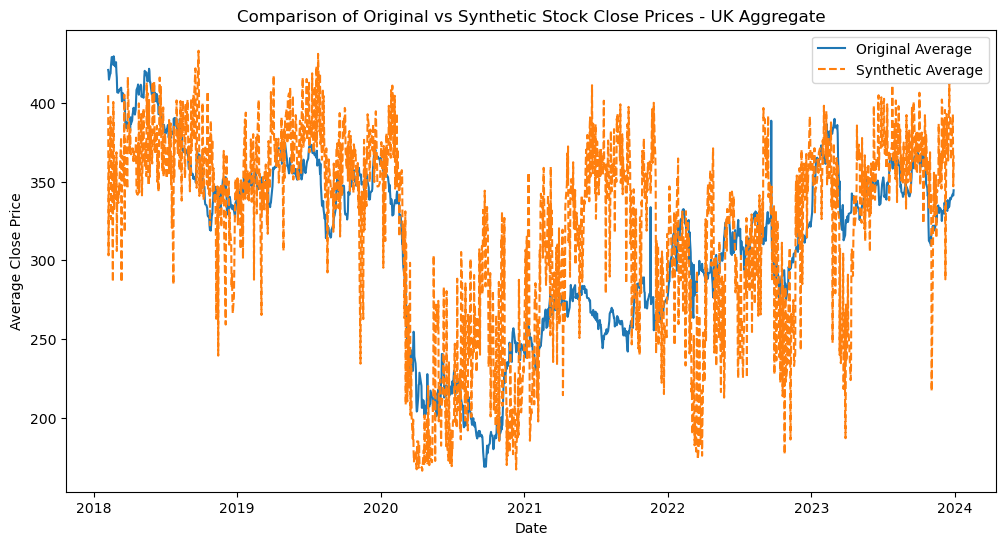

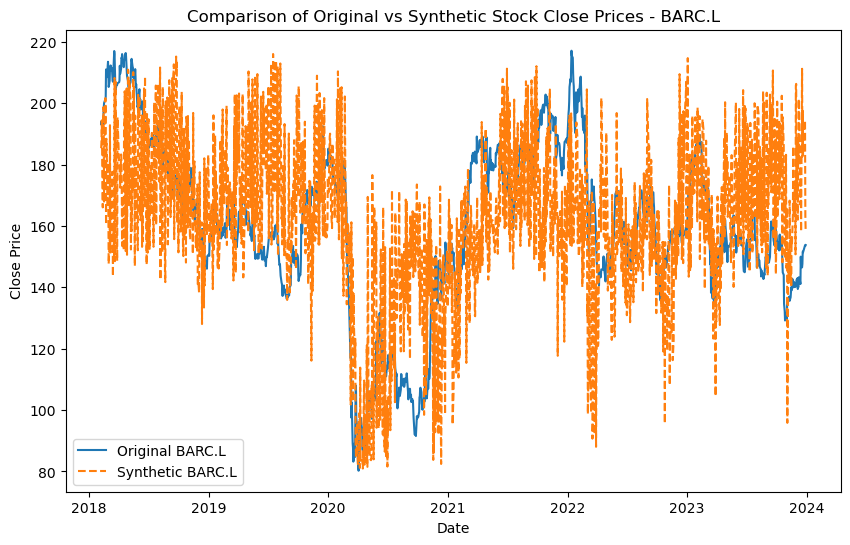

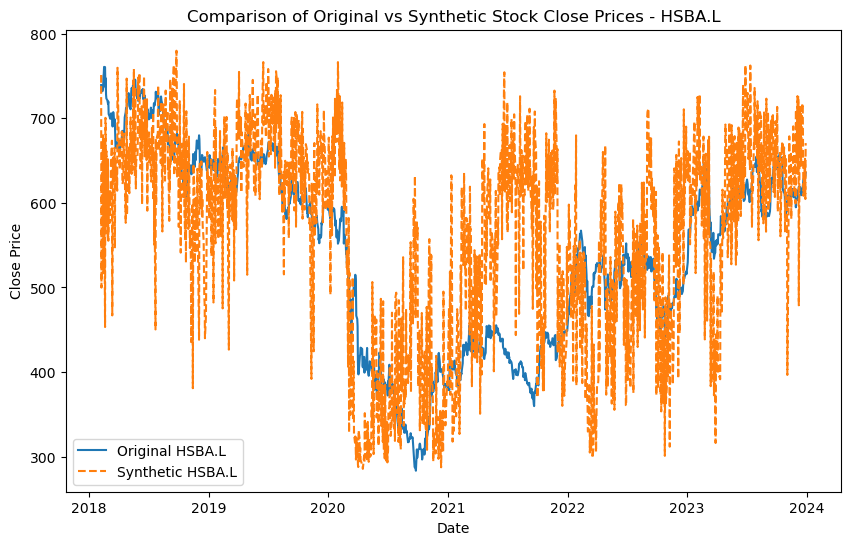

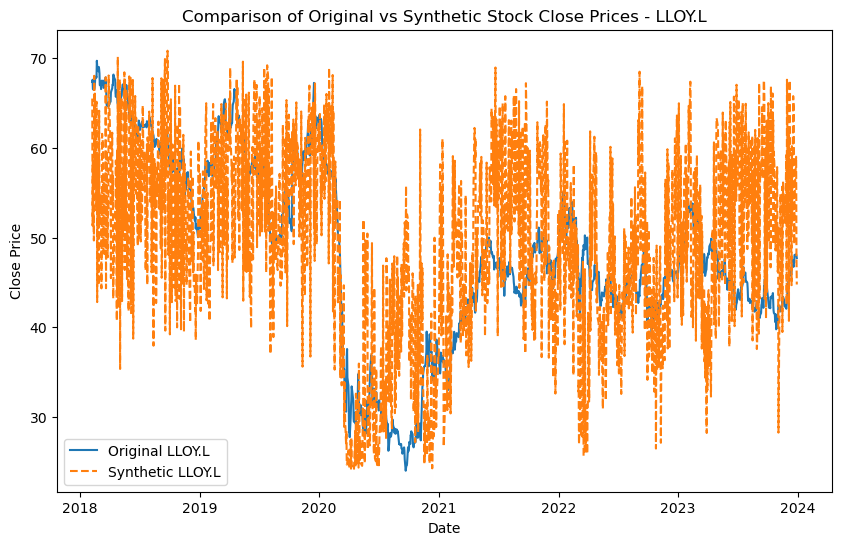

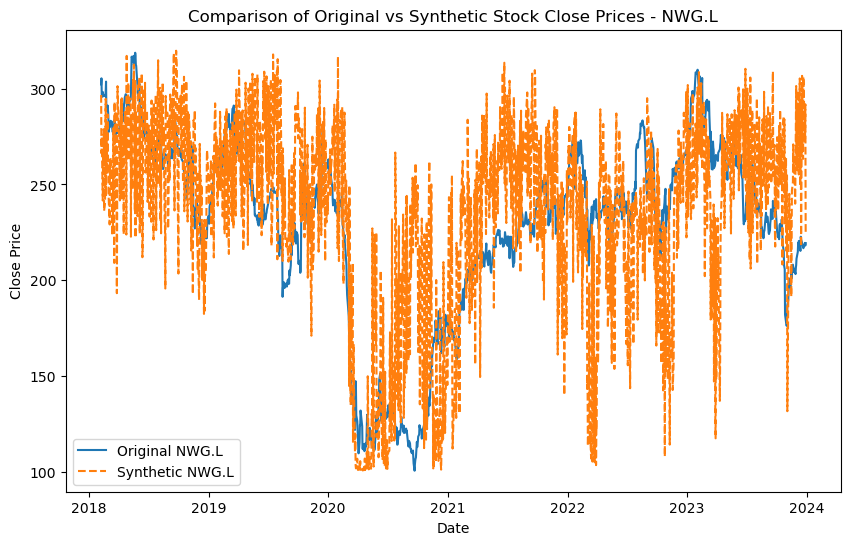

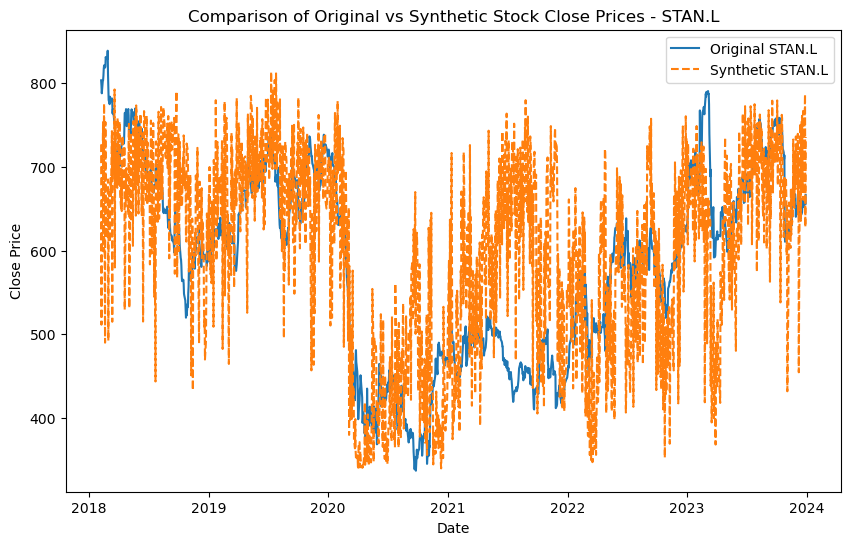


Original Data Statistics:
Ticker       BARC.L       HSBA.L       LLOY.L        NWG.L       STAN.L
count   1513.000000  1514.000000  1512.000000  1514.000000  1514.000000
mean     161.133496   545.218440    48.746692   230.710961   588.857523
std       27.520135   116.144725    10.670739    48.732321   116.942598
min       80.239998   283.350006    23.980000   100.498398   336.799988
25%      147.699997   438.237503    42.770000   215.201904   487.525002
50%      160.720001   564.349976    47.335001   237.999893   607.200012
75%      180.399994   638.900024    57.692499   263.846100   683.949997
max      217.100006   796.000000    72.120003   325.661499   849.200012

Synthetic Data Statistics:
Ticker       BARC.L       HSBA.L       LLOY.L        NWG.L       STAN.L
count   1488.000000  1488.000000  1488.000000  1488.000000  1488.000000
mean     161.468552   563.444214    49.270691   235.578842   603.875854
std       26.616491   122.100250    10.931603    51.835178   118.139183
min      

C:\Users\hassa\AppData\Local\Temp\ipykernel_12472\328582907.py:175: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_avg, label='Original Average', shade=True)
C:\Users\hassa\AppData\Local\Temp\ipykernel_12472\328582907.py:176: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_avg, label='Synthetic Average', shade=True)


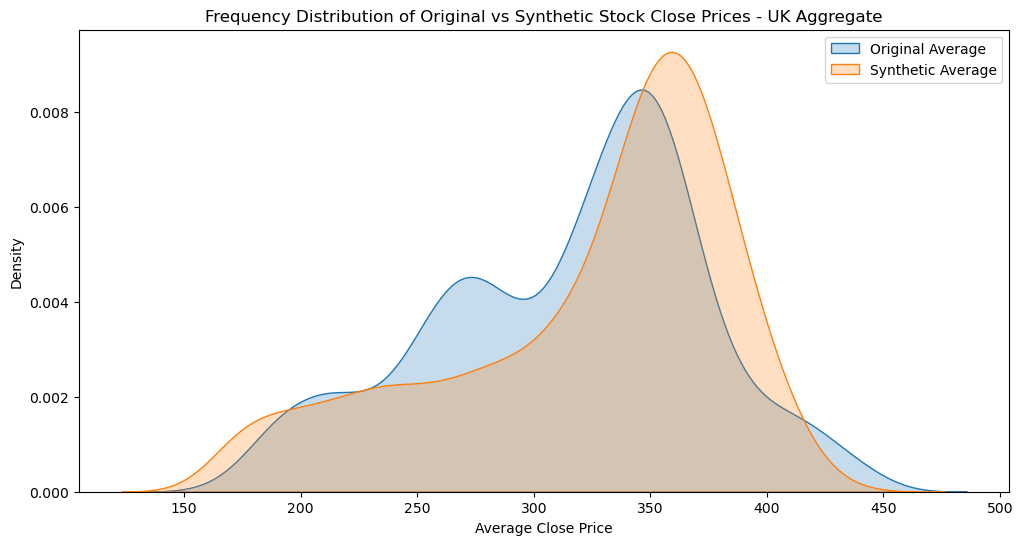

C:\Users\hassa\AppData\Local\Temp\ipykernel_12472\328582907.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_data[column], label=f'Original {column}', shade=True)
C:\Users\hassa\AppData\Local\Temp\ipykernel_12472\328582907.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_data[column], label=f'Synthetic {column}', shade=True)


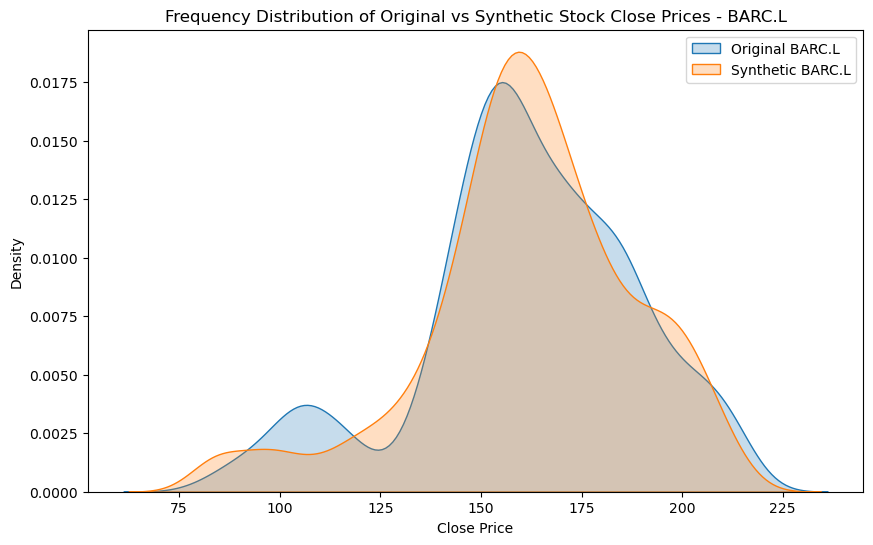

C:\Users\hassa\AppData\Local\Temp\ipykernel_12472\328582907.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_data[column], label=f'Original {column}', shade=True)
C:\Users\hassa\AppData\Local\Temp\ipykernel_12472\328582907.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_data[column], label=f'Synthetic {column}', shade=True)


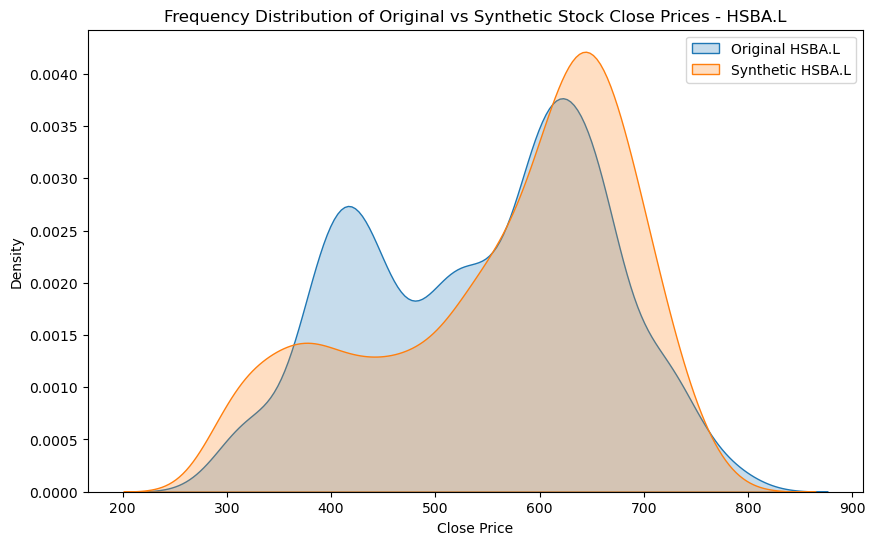

C:\Users\hassa\AppData\Local\Temp\ipykernel_12472\328582907.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_data[column], label=f'Original {column}', shade=True)
C:\Users\hassa\AppData\Local\Temp\ipykernel_12472\328582907.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_data[column], label=f'Synthetic {column}', shade=True)


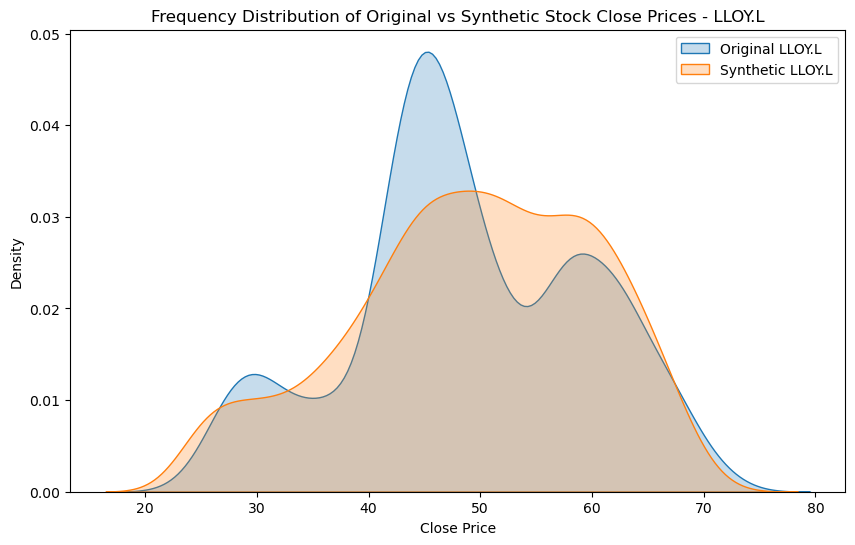

C:\Users\hassa\AppData\Local\Temp\ipykernel_12472\328582907.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_data[column], label=f'Original {column}', shade=True)
C:\Users\hassa\AppData\Local\Temp\ipykernel_12472\328582907.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_data[column], label=f'Synthetic {column}', shade=True)


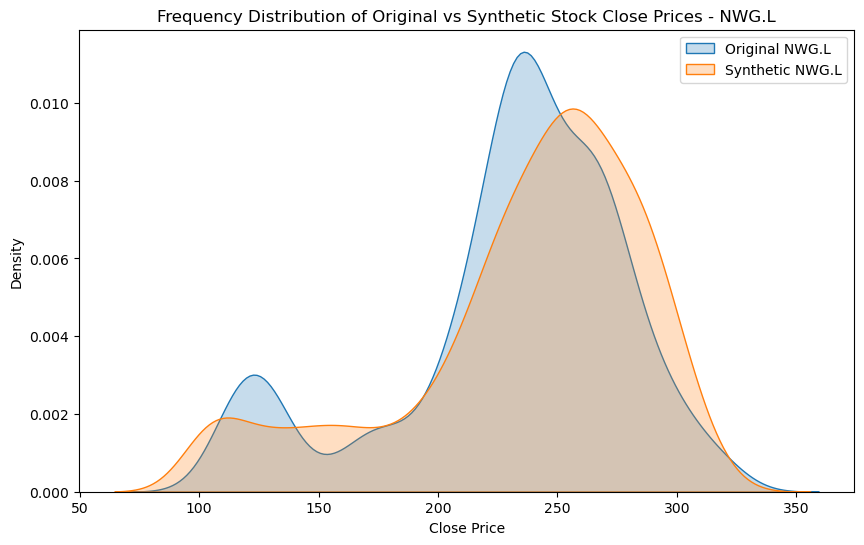

C:\Users\hassa\AppData\Local\Temp\ipykernel_12472\328582907.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_data[column], label=f'Original {column}', shade=True)
C:\Users\hassa\AppData\Local\Temp\ipykernel_12472\328582907.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_data[column], label=f'Synthetic {column}', shade=True)


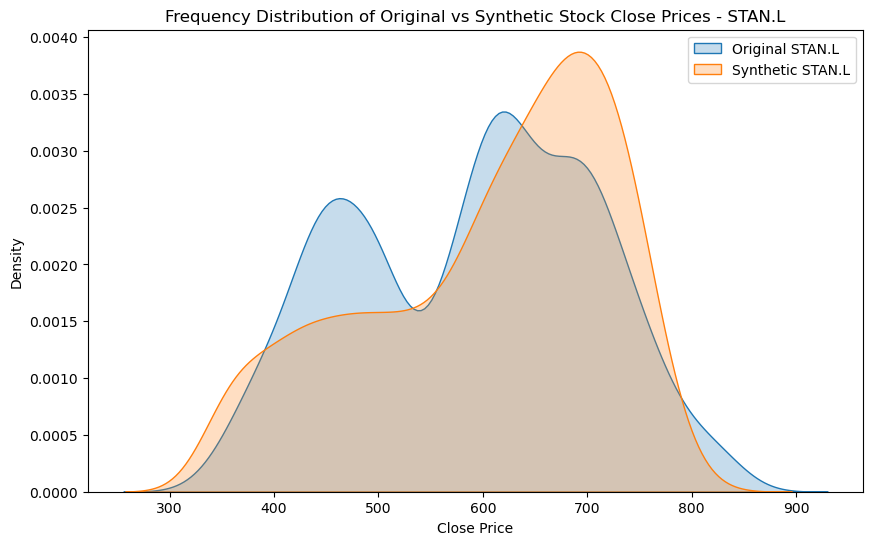

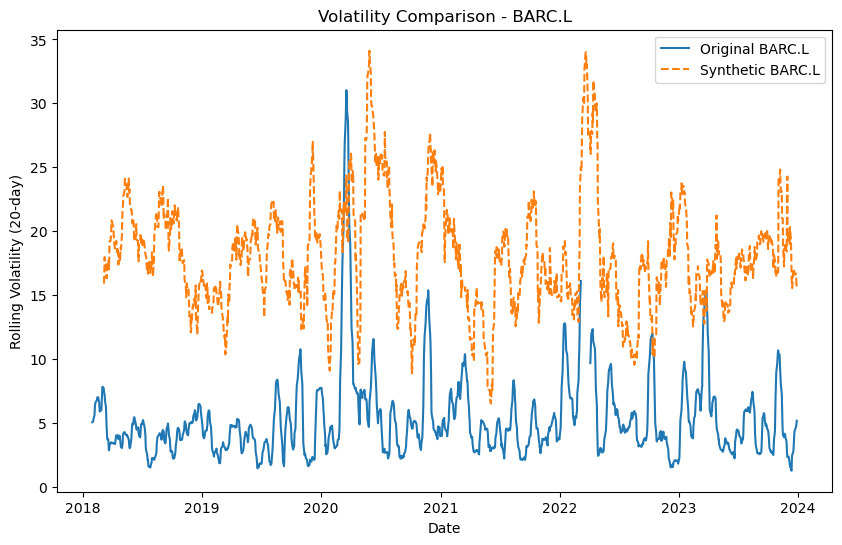


Volatility Statistics for BARC.L:
Original Volatility:
count    1475.000000
mean        5.293801
std         3.366730
min         1.271621
25%         3.295593
50%         4.490042
75%         6.137885
max        31.034778
Name: BARC.L, dtype: float64

Synthetic Volatility:
count    1469.000000
mean       18.012437
std         4.302688
min         6.534033
25%        15.156547
50%        17.720085
75%        20.258178
max        34.115886
Name: BARC.L, dtype: float64


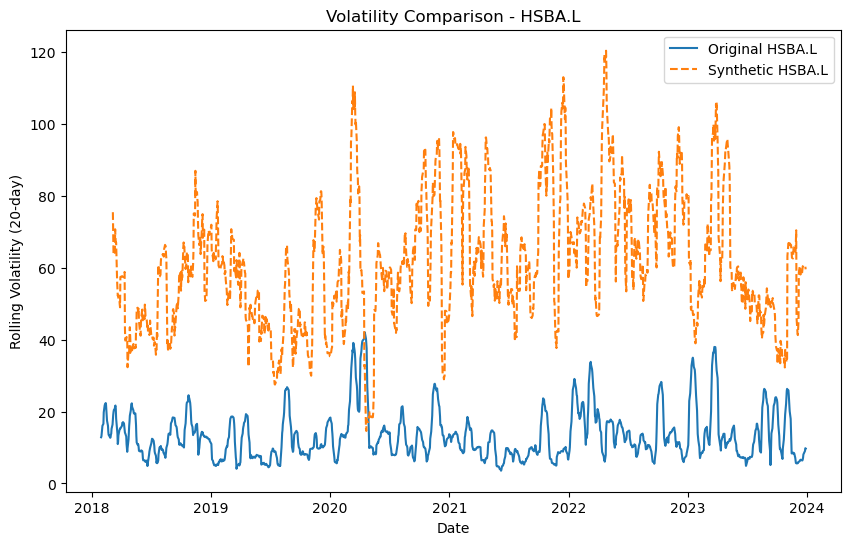


Volatility Statistics for HSBA.L:
Original Volatility:
count    1495.000000
mean       13.364775
std         6.905325
min         3.529399
25%         8.431178
50%        11.589878
75%        16.166048
max        42.045990
Name: HSBA.L, dtype: float64

Synthetic Volatility:
count    1469.000000
mean       61.407672
std        18.449830
min        14.586747
25%        48.345699
50%        59.428252
75%        72.013289
max       120.345723
Name: HSBA.L, dtype: float64


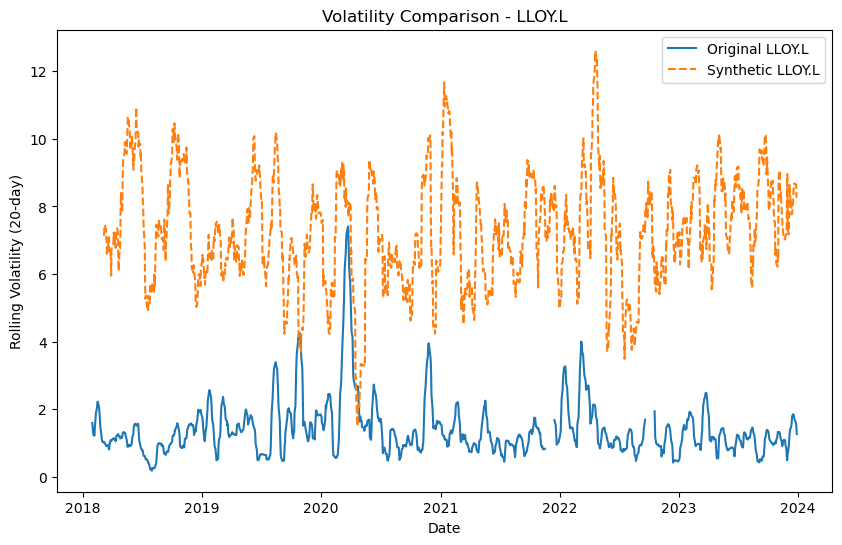


Volatility Statistics for LLOY.L:
Original Volatility:
count    1455.000000
mean        1.417889
std         0.875438
min         0.185539
25%         0.926578
50%         1.217176
75%         1.603762
max         7.403312
Name: LLOY.L, dtype: float64

Synthetic Volatility:
count    1469.000000
mean        7.261692
std         1.638421
min         1.498252
25%         6.212535
50%         7.167599
75%         8.424786
max        12.603968
Name: LLOY.L, dtype: float64


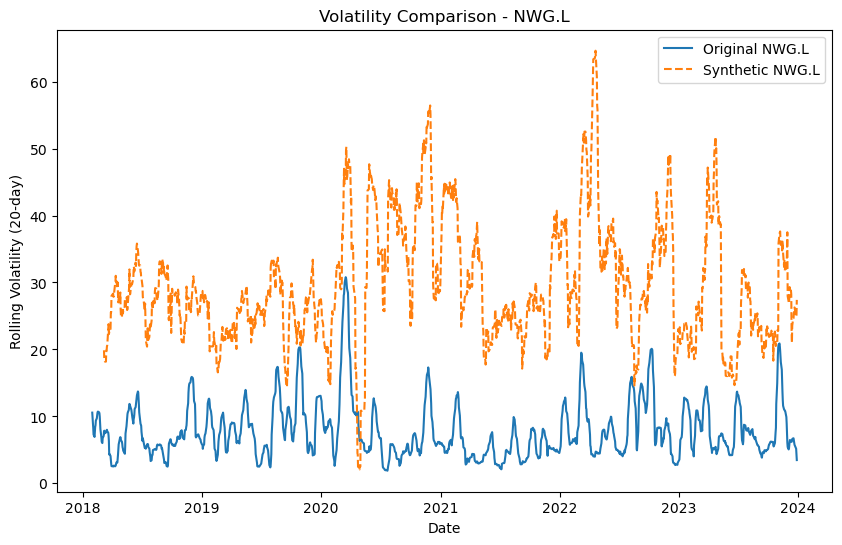


Volatility Statistics for NWG.L:
Original Volatility:
count    1495.000000
mean        7.881989
std         4.312743
min         1.886791
25%         4.940239
50%         6.724385
75%         9.882302
max        30.791112
Name: NWG.L, dtype: float64

Synthetic Volatility:
count    1469.000000
mean       29.526589
std         9.028934
min         2.049273
25%        23.349435
50%        27.857582
75%        34.391171
max        64.609278
Name: NWG.L, dtype: float64


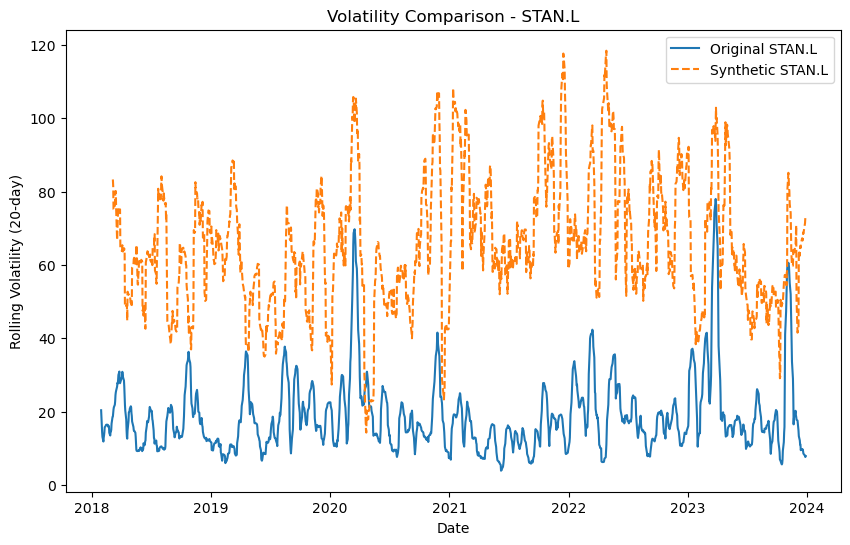


Volatility Statistics for STAN.L:
Original Volatility:
count    1495.000000
mean       18.813624
std        10.400963
min         3.844531
25%        12.295816
50%        16.383868
75%        22.133051
max        77.996652
Name: STAN.L, dtype: float64

Synthetic Volatility:
count    1469.000000
mean       65.547138
std        17.929048
min        14.258322
25%        53.446663
50%        63.517480
75%        76.464148
max       118.443418
Name: STAN.L, dtype: float64

Risk Metrics for BARC.L:
Original Data:
VaR: -0.0320
CVaR: -0.0515

Synthetic Data:
VaR: -0.2266
CVaR: -0.2822

Risk Metrics for HSBA.L:
Original Data:
VaR: -0.0272
CVaR: -0.0397

Synthetic Data:
VaR: -0.2267
CVaR: -0.2861

Risk Metrics for LLOY.L:
Original Data:
VaR: -0.0300
CVaR: -0.0478

Synthetic Data:
VaR: -0.3003
CVaR: -0.3515

Risk Metrics for NWG.L:
Original Data:
VaR: -0.0336
CVaR: -0.0537

Synthetic Data:
VaR: -0.2560
CVaR: -0.3353

Risk Metrics for STAN.L:
Original Data:
VaR: -0.0315
CVaR: -0.0511

Synthetic D

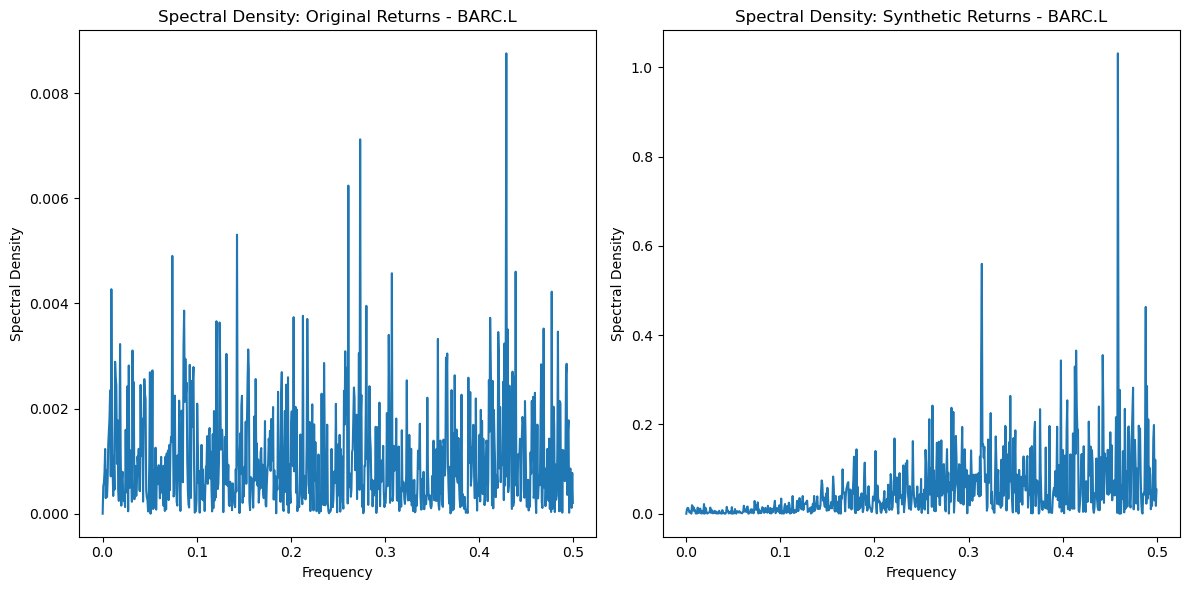


Spectral Analysis for BARC.L:
Original Returns - Spectral Density Statistics:
Max: 0.00876
Min: 0.00000
Mean: 0.00102
Standard Deviation: 0.00100

Synthetic Returns - Spectral Density Statistics:
Max: 1.03158
Min: 0.00000
Mean: 0.05380
Standard Deviation: 0.07624


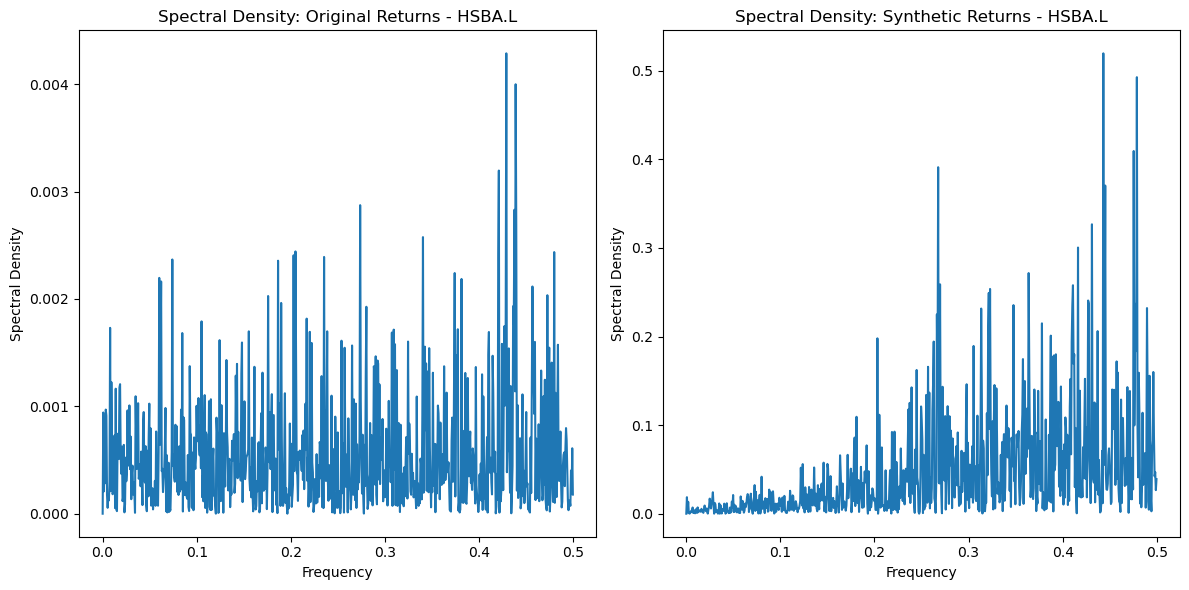


Spectral Analysis for HSBA.L:
Original Returns - Spectral Density Statistics:
Max: 0.00429
Min: 0.00000
Mean: 0.00056
Standard Deviation: 0.00056

Synthetic Returns - Spectral Density Statistics:
Max: 0.51976
Min: 0.00000
Mean: 0.04689
Standard Deviation: 0.06298


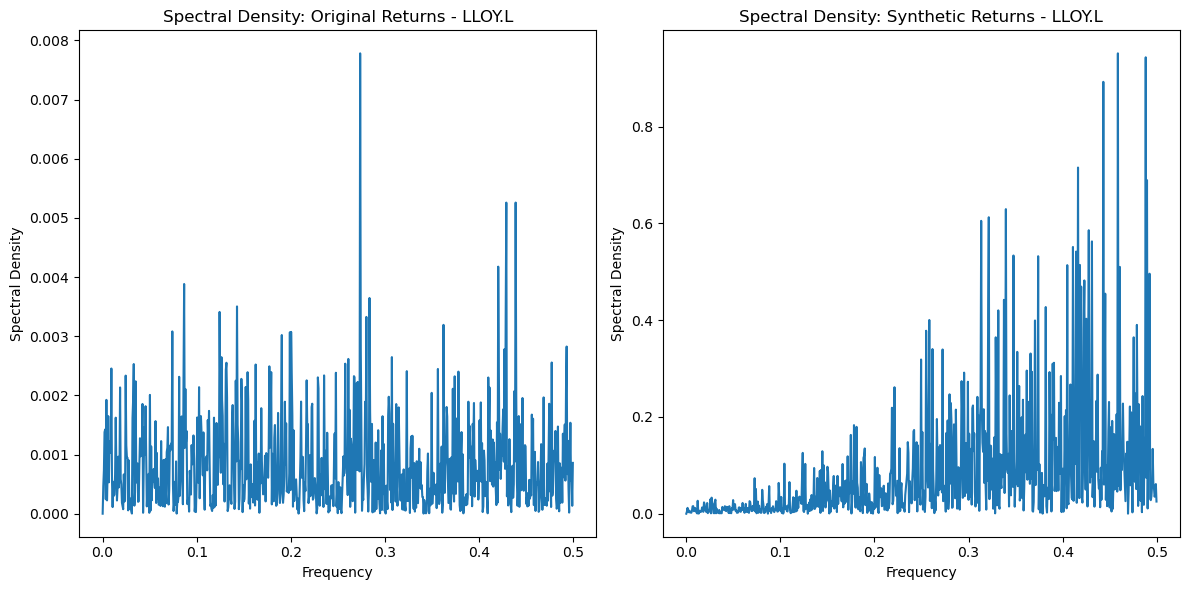


Spectral Analysis for LLOY.L:
Original Returns - Spectral Density Statistics:
Max: 0.00778
Min: 0.00000
Mean: 0.00083
Standard Deviation: 0.00081

Synthetic Returns - Spectral Density Statistics:
Max: 0.95147
Min: 0.00000
Mean: 0.08556
Standard Deviation: 0.12404


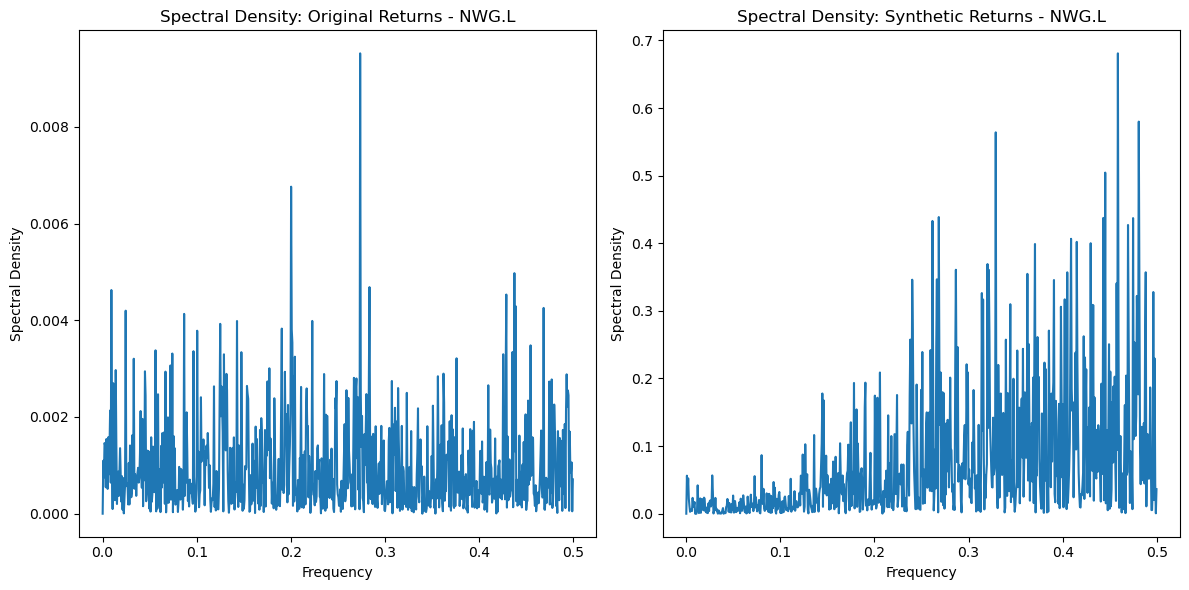


Spectral Analysis for NWG.L:
Original Returns - Spectral Density Statistics:
Max: 0.00952
Min: 0.00000
Mean: 0.00098
Standard Deviation: 0.00098

Synthetic Returns - Spectral Density Statistics:
Max: 0.68082
Min: 0.00000
Mean: 0.07531
Standard Deviation: 0.09517


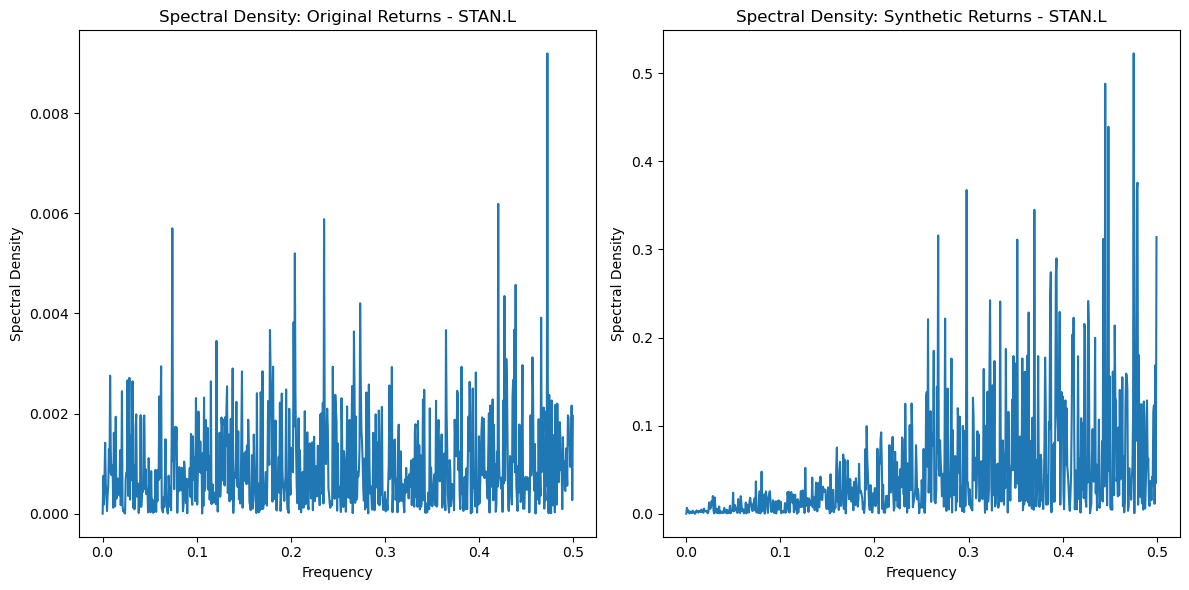


Spectral Analysis for STAN.L:
Original Returns - Spectral Density Statistics:
Max: 0.00920
Min: 0.00000
Mean: 0.00094
Standard Deviation: 0.00094

Synthetic Returns - Spectral Density Statistics:
Max: 0.52265
Min: 0.00000
Mean: 0.04596
Standard Deviation: 0.06581

Additional Metrics for BARC.L:
Correlation: nan
Mean Squared Error: 752.5331
Mean Absolute Error: 22.0299

Additional Metrics for HSBA.L:
Correlation: 0.6183
Mean Squared Error: 11113.9831
Mean Absolute Error: 81.0685

Additional Metrics for LLOY.L:
Correlation: nan
Mean Squared Error: 103.9155
Mean Absolute Error: 8.1267

Additional Metrics for NWG.L:
Correlation: 0.5985
Mean Squared Error: 2047.7306
Mean Absolute Error: 35.6319

Additional Metrics for STAN.L:
Correlation: 0.5927
Mean Squared Error: 11342.3987
Mean Absolute Error: 81.7740


In [18]:
# Cell 8: Analyze results
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, skew, kurtosis
from scipy.signal import periodogram

def plot_comparison(original_data, synthetic_data, title):
    common_index = original_data.index.intersection(synthetic_data.index)
    aligned_original = original_data.loc[common_index]
    aligned_synthetic = synthetic_data.loc[common_index]

    for column in aligned_original.columns:
        plt.figure(figsize=(10, 6))
        plt.plot(aligned_original.index, aligned_original[column], label=f'Original {column}')
        plt.plot(aligned_synthetic.index, aligned_synthetic[column], label=f'Synthetic {column}', linestyle='dashed')
        plt.title(f"{title} - {column}")
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.show()

def compute_statistics(data):
    return data.describe()

def plot_distribution(original_data, synthetic_data, title):
    for column in original_data.columns:
        plt.figure(figsize=(10, 6))
        sns.kdeplot(original_data[column], label=f'Original {column}', shade=True)
        sns.kdeplot(synthetic_data[column], label=f'Synthetic {column}', shade=True)
        plt.title(f"{title} - {column}")
        plt.xlabel('Close Price')
        plt.ylabel('Density')
        plt.legend()
        plt.show()

def analyze_volatility(original_data, synthetic_data, window=20):
    for column in original_data.columns:
        original_volatility = original_data[column].rolling(window=window).std()
        synthetic_volatility = synthetic_data[column].rolling(window=window).std()
        
        plt.figure(figsize=(10, 6))
        plt.plot(original_volatility.index, original_volatility, label=f'Original {column}')
        plt.plot(synthetic_volatility.index, synthetic_volatility, label=f'Synthetic {column}', linestyle='dashed')
        plt.title(f'Volatility Comparison - {column}')
        plt.xlabel('Date')
        plt.ylabel(f'Rolling Volatility ({window}-day)')
        plt.legend()
        plt.show()
        
        print(f"\nVolatility Statistics for {column}:")
        print("Original Volatility:")
        print(original_volatility.describe())
        print("\nSynthetic Volatility:")
        print(synthetic_volatility.describe())

def compute_var_cvar(returns, alpha=0.05):
    sorted_returns = returns.sort_values()
    var = sorted_returns.quantile(alpha)
    cvar = sorted_returns[sorted_returns <= var].mean()
    return var, cvar

def analyze_risk_metrics(original_data, synthetic_data):
    for column in original_data.columns:
        original_returns = original_data[column].pct_change().dropna()
        synthetic_returns = synthetic_data[column].pct_change().dropna()
        
        original_var, original_cvar = compute_var_cvar(original_returns)
        synthetic_var, synthetic_cvar = compute_var_cvar(synthetic_returns)
        
        print(f"\nRisk Metrics for {column}:")
        print("Original Data:")
        print(f"VaR: {original_var:.4f}")
        print(f"CVaR: {original_cvar:.4f}")
        print("\nSynthetic Data:")
        print(f"VaR: {synthetic_var:.4f}")
        print(f"CVaR: {synthetic_cvar:.4f}")

def analyze_distribution(original_data, synthetic_data):
    for column in original_data.columns:
        original_returns = original_data[column].pct_change().dropna()
        synthetic_returns = synthetic_data[column].pct_change().dropna()
        
        ks_statistic, ks_pvalue = ks_2samp(original_returns, synthetic_returns)
        original_skewness = skew(original_returns)
        synthetic_skewness = skew(synthetic_returns)
        original_kurtosis = kurtosis(original_returns)
        synthetic_kurtosis = kurtosis(synthetic_returns)
        
        print(f"\nDistribution Analysis for {column}:")
        print(f"K-S Statistic: {ks_statistic:.4f}")
        print(f"K-S P-value: {ks_pvalue:.4f}")
        print(f"Original Skewness: {original_skewness:.4f}")
        print(f"Synthetic Skewness: {synthetic_skewness:.4f}")
        print(f"Original Kurtosis: {original_kurtosis:.4f}")
        print(f"Synthetic Kurtosis: {synthetic_kurtosis:.4f}")

def analyze_spectrum(original_data, synthetic_data):
    for column in original_data.columns:
        original_returns = original_data[column].pct_change().dropna()
        synthetic_returns = synthetic_data[column].pct_change().dropna()
        
        f_original, Pxx_original = periodogram(original_returns)
        f_synthetic, Pxx_synthetic = periodogram(synthetic_returns)
        
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(f_original, Pxx_original)
        plt.title(f'Spectral Density: Original Returns - {column}')
        plt.xlabel('Frequency')
        plt.ylabel('Spectral Density')
        
        plt.subplot(1, 2, 2)
        plt.plot(f_synthetic, Pxx_synthetic)
        plt.title(f'Spectral Density: Synthetic Returns - {column}')
        plt.xlabel('Frequency')
        plt.ylabel('Spectral Density')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nSpectral Analysis for {column}:")
        print("Original Returns - Spectral Density Statistics:")
        print(f"Max: {np.max(Pxx_original):.5f}")
        print(f"Min: {np.min(Pxx_original):.5f}")
        print(f"Mean: {np.mean(Pxx_original):.5f}")
        print(f"Standard Deviation: {np.std(Pxx_original):.5f}")
        
        print("\nSynthetic Returns - Spectral Density Statistics:")
        print(f"Max: {np.max(Pxx_synthetic):.5f}")
        print(f"Min: {np.min(Pxx_synthetic):.5f}")
        print(f"Mean: {np.mean(Pxx_synthetic):.5f}")
        print(f"Standard Deviation: {np.std(Pxx_synthetic):.5f}")

def calculate_additional_metrics(original_data, synthetic_data):
    # Ensure both datasets have the same index
    common_index = original_data.index.intersection(synthetic_data.index)
    aligned_original = original_data.loc[common_index]
    aligned_synthetic = synthetic_data.loc[common_index]

    for column in aligned_original.columns:
        correlation = np.corrcoef(aligned_original[column], aligned_synthetic[column])[0, 1]
        mse = np.mean((aligned_original[column] - aligned_synthetic[column]) ** 2)
        mae = np.mean(np.abs(aligned_original[column] - aligned_synthetic[column]))
        
        print(f"\nAdditional Metrics for {column}:")
        print(f"Correlation: {correlation:.4f}")
        print(f"Mean Squared Error: {mse:.4f}")
        print(f"Mean Absolute Error: {mae:.4f}")
def plot_aggregate_comparison(original_data, synthetic_data, title):
    common_index = original_data.index.intersection(synthetic_data.index)
    aligned_original = original_data.loc[common_index]
    aligned_synthetic = synthetic_data.loc[common_index]

    # Calculate average across all stocks
    original_avg = aligned_original.mean(axis=1)
    synthetic_avg = aligned_synthetic.mean(axis=1)

    plt.figure(figsize=(12, 6))
    plt.plot(common_index, original_avg, label='Original Average')
    plt.plot(common_index, synthetic_avg, label='Synthetic Average', linestyle='dashed')
    plt.title(f"{title} - UK Aggregate")
    plt.xlabel('Date')
    plt.ylabel('Average Close Price')
    plt.legend()
    plt.show()

def plot_aggregate_distribution(original_data, synthetic_data, title):
    # Calculate average across all stocks
    original_avg = original_data.mean(axis=1)
    synthetic_avg = synthetic_data.mean(axis=1)

    plt.figure(figsize=(12, 6))
    sns.kdeplot(original_avg, label='Original Average', shade=True)
    sns.kdeplot(synthetic_avg, label='Synthetic Average', shade=True)
    plt.title(f"{title} - UK Aggregate")
    plt.xlabel('Average Close Price')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


# Main execution
plot_aggregate_comparison(stock_data, rescaled_synthetic_data, "Comparison of Original vs Synthetic Stock Close Prices")
plot_comparison(stock_data, rescaled_synthetic_data, "Comparison of Original vs Synthetic Stock Close Prices")

print("\nOriginal Data Statistics:")
print(compute_statistics(stock_data))
print("\nSynthetic Data Statistics:")
print(compute_statistics(rescaled_synthetic_data))

print(compute_statistics(rescaled_synthetic_data))
plot_aggregate_distribution(stock_data, rescaled_synthetic_data, "Frequency Distribution of Original vs Synthetic Stock Close Prices")
plot_distribution(stock_data, rescaled_synthetic_data, "Frequency Distribution of Original vs Synthetic Stock Close Prices")

analyze_volatility(stock_data, rescaled_synthetic_data)
analyze_risk_metrics(stock_data, rescaled_synthetic_data)
analyze_distribution(stock_data, rescaled_synthetic_data)
analyze_spectrum(stock_data, rescaled_synthetic_data)
calculate_additional_metrics(stock_data, rescaled_synthetic_data)

# Risk Metric Analysis

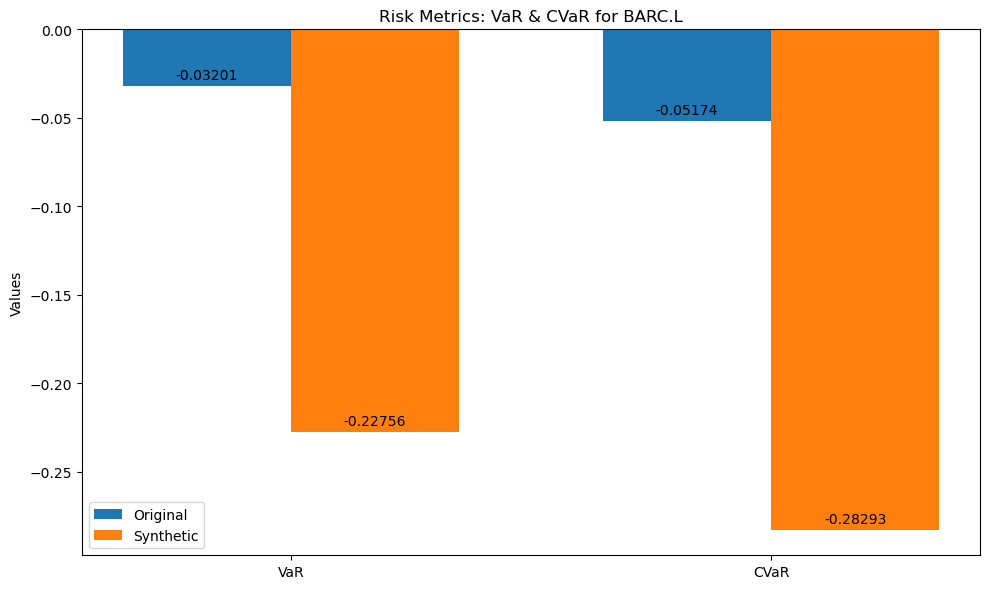


Risk Metrics for BARC.L:
Original Data Metrics:
VaR: -0.03201
CVaR: -0.05174

Synthetic Data Metrics:
VaR: -0.22756
CVaR: -0.28293


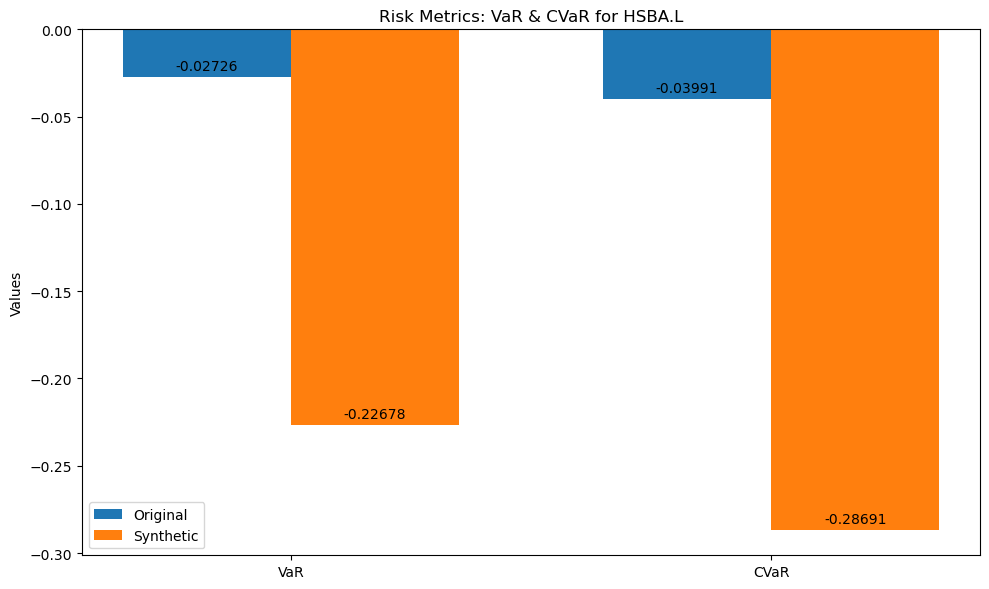


Risk Metrics for HSBA.L:
Original Data Metrics:
VaR: -0.02726
CVaR: -0.03991

Synthetic Data Metrics:
VaR: -0.22678
CVaR: -0.28691


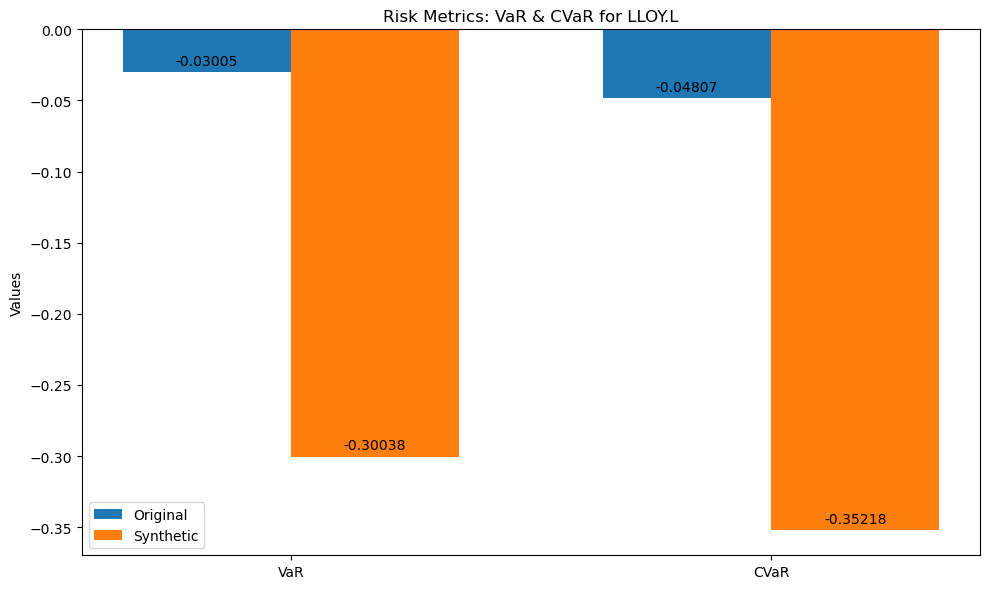


Risk Metrics for LLOY.L:
Original Data Metrics:
VaR: -0.03005
CVaR: -0.04807

Synthetic Data Metrics:
VaR: -0.30038
CVaR: -0.35218


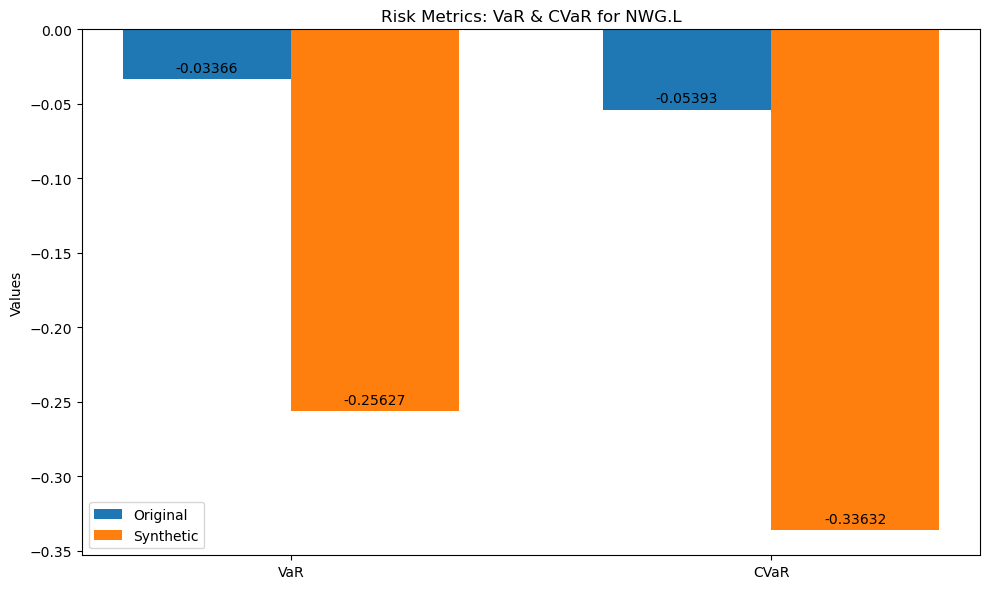


Risk Metrics for NWG.L:
Original Data Metrics:
VaR: -0.03366
CVaR: -0.05393

Synthetic Data Metrics:
VaR: -0.25627
CVaR: -0.33632


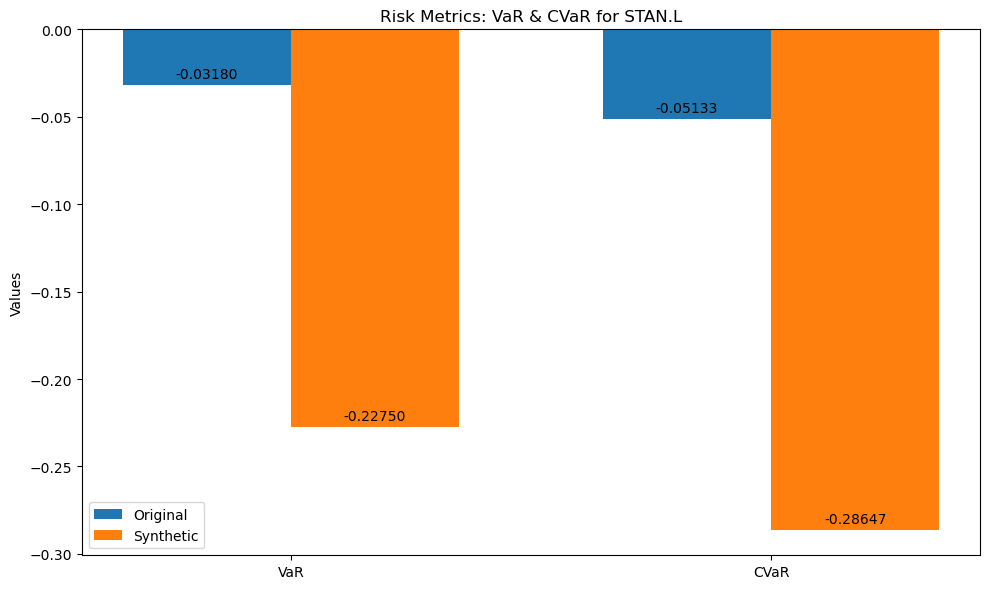


Risk Metrics for STAN.L:
Original Data Metrics:
VaR: -0.03180
CVaR: -0.05133

Synthetic Data Metrics:
VaR: -0.22750
CVaR: -0.28647


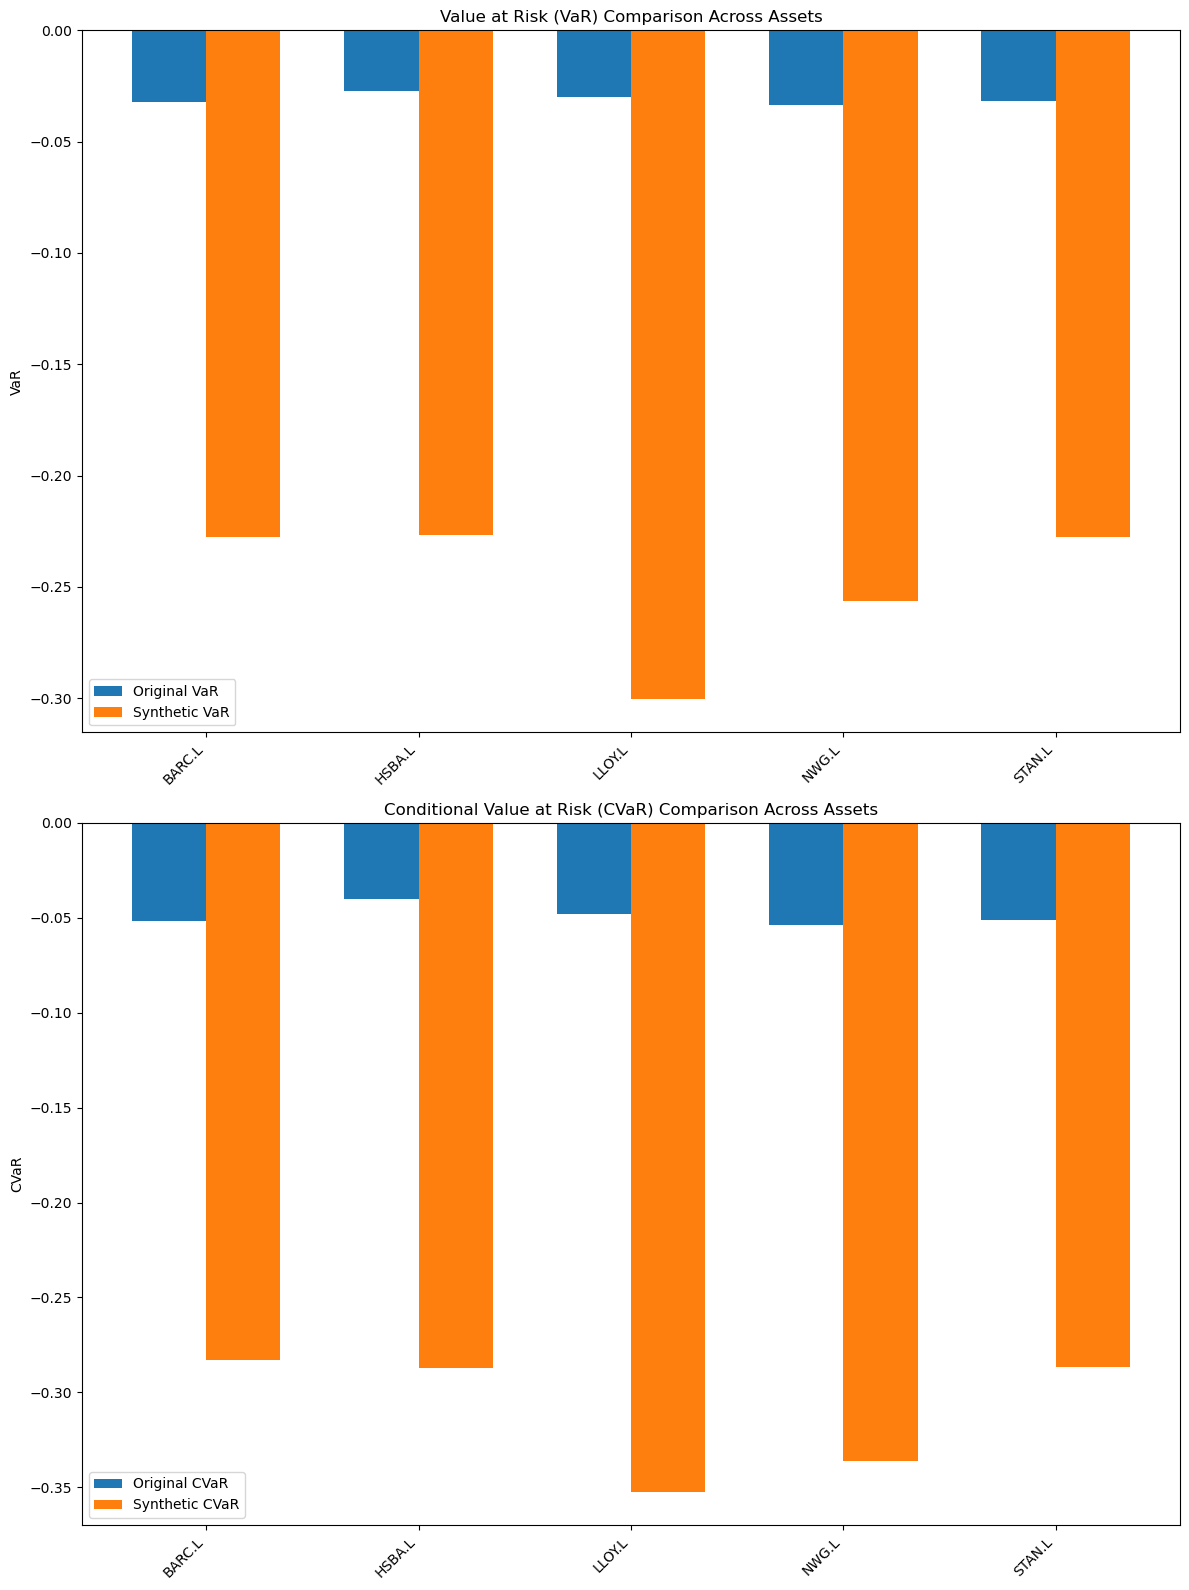


Original Portfolio:

Portfolio Risk Metrics:
VaR: -0.02626
CVaR: -0.04187

Synthetic Portfolio:

Portfolio Risk Metrics:
VaR: -0.19225
CVaR: -0.25060


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def compute_var_cvar(returns, alpha=0.05):
    """
    Compute VaR and CVaR for given returns and alpha.
    """
    sorted_returns = returns.sort_values()
    index = int(alpha * len(sorted_returns))
    VaR = sorted_returns.iloc[index]
    CVaR = sorted_returns.iloc[:index].mean()
    return VaR, CVaR

def analyze_risk_metrics(original_data, synthetic_data):
    original_returns = original_data.pct_change().dropna()
    synthetic_returns = synthetic_data.pct_change().dropna()

    original_vars = []
    original_cvars = []
    synthetic_vars = []
    synthetic_cvars = []
    assets = []

    for column in original_returns.columns:
        original_var, original_cvar = compute_var_cvar(original_returns[column])
        synthetic_var, synthetic_cvar = compute_var_cvar(synthetic_returns[column])

        original_vars.append(original_var)
        original_cvars.append(original_cvar)
        synthetic_vars.append(synthetic_var)
        synthetic_cvars.append(synthetic_cvar)
        assets.append(column)

        # Individual asset visualization (unchanged)
        labels = ['VaR', 'CVaR']
        original_metrics = [original_var, original_cvar]
        synthetic_metrics = [synthetic_var, synthetic_cvar]

        x = np.arange(len(labels))
        width = 0.35

        fig, ax = plt.subplots(figsize=(10, 6))
        rects1 = ax.bar(x - width/2, original_metrics, width, label='Original')
        rects2 = ax.bar(x + width/2, synthetic_metrics, width, label='Synthetic')

        ax.set_ylabel('Values')
        ax.set_title(f'Risk Metrics: VaR & CVaR for {column}')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()

        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.5f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')

        autolabel(rects1)
        autolabel(rects2)

        plt.tight_layout()
        plt.show()

        # Display the VaR and CVaR for both datasets
        print(f"\nRisk Metrics for {column}:")
        print("Original Data Metrics:")
        print(f"VaR: {original_var:.5f}")
        print(f"CVaR: {original_cvar:.5f}")

        print("\nSynthetic Data Metrics:")
        print(f"VaR: {synthetic_var:.5f}")
        print(f"CVaR: {synthetic_cvar:.5f}")

    # Aggregate chart for all assets
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
    x = np.arange(len(assets))
    width = 0.35

    # VaR comparison
    ax1.bar(x - width/2, original_vars, width, label='Original VaR')
    ax1.bar(x + width/2, synthetic_vars, width, label='Synthetic VaR')
    ax1.set_ylabel('VaR')
    ax1.set_title('Value at Risk (VaR) Comparison Across Assets')
    ax1.set_xticks(x)
    ax1.set_xticklabels(assets, rotation=45, ha='right')
    ax1.legend()

    # CVaR comparison
    ax2.bar(x - width/2, original_cvars, width, label='Original CVaR')
    ax2.bar(x + width/2, synthetic_cvars, width, label='Synthetic CVaR')
    ax2.set_ylabel('CVaR')
    ax2.set_title('Conditional Value at Risk (CVaR) Comparison Across Assets')
    ax2.set_xticks(x)
    ax2.set_xticklabels(assets, rotation=45, ha='right')
    ax2.legend()

    plt.tight_layout()
    plt.show()

def analyze_portfolio_risk(data, weights=None):
    if weights is None:
        weights = np.ones(len(data.columns)) / len(data.columns)  # Equal weights if not provided
    
    portfolio_returns = (data.pct_change().dropna() * weights).sum(axis=1)
    var, cvar = compute_var_cvar(portfolio_returns)
    
    print("\nPortfolio Risk Metrics:")
    print(f"VaR: {var:.5f}")
    print(f"CVaR: {cvar:.5f}")

# Assuming stock_data and rescaled_synthetic_data are available
# If they're not, you might need to load or recreate them here

# Perform the risk metric analysis
analyze_risk_metrics(stock_data, rescaled_synthetic_data)

print("\nOriginal Portfolio:")
analyze_portfolio_risk(stock_data)

print("\nSynthetic Portfolio:")
analyze_portfolio_risk(rescaled_synthetic_data)

# Distributional Analysis


Distributional Analysis for BARC.L:
K-S Statistic: 0.3605
K-S P-value: 0.0000

Metrics		Original	Synthetic
Skewness:	0.0479		0.8523
Kurtosis:	7.8941		2.8430


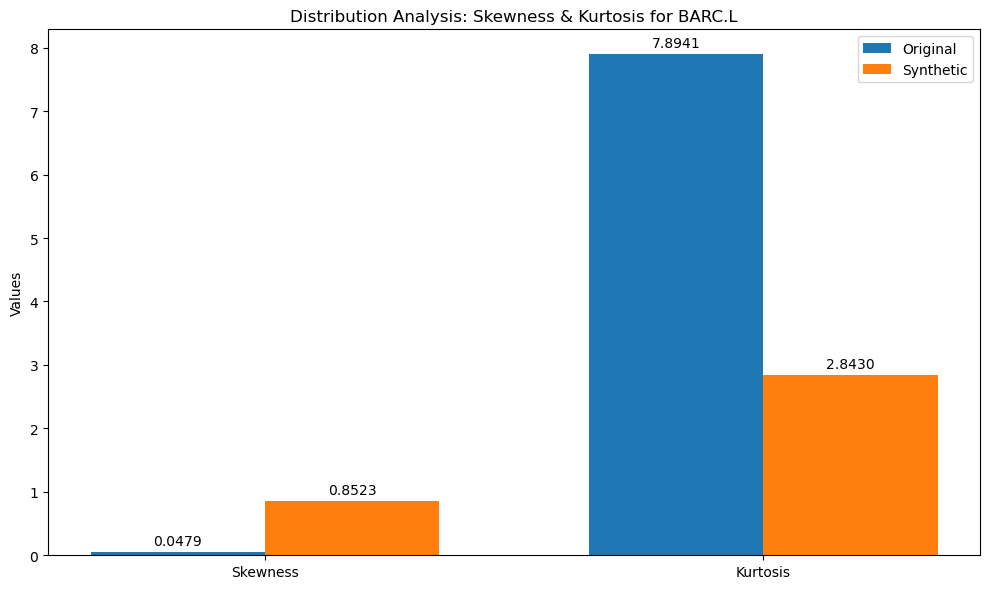

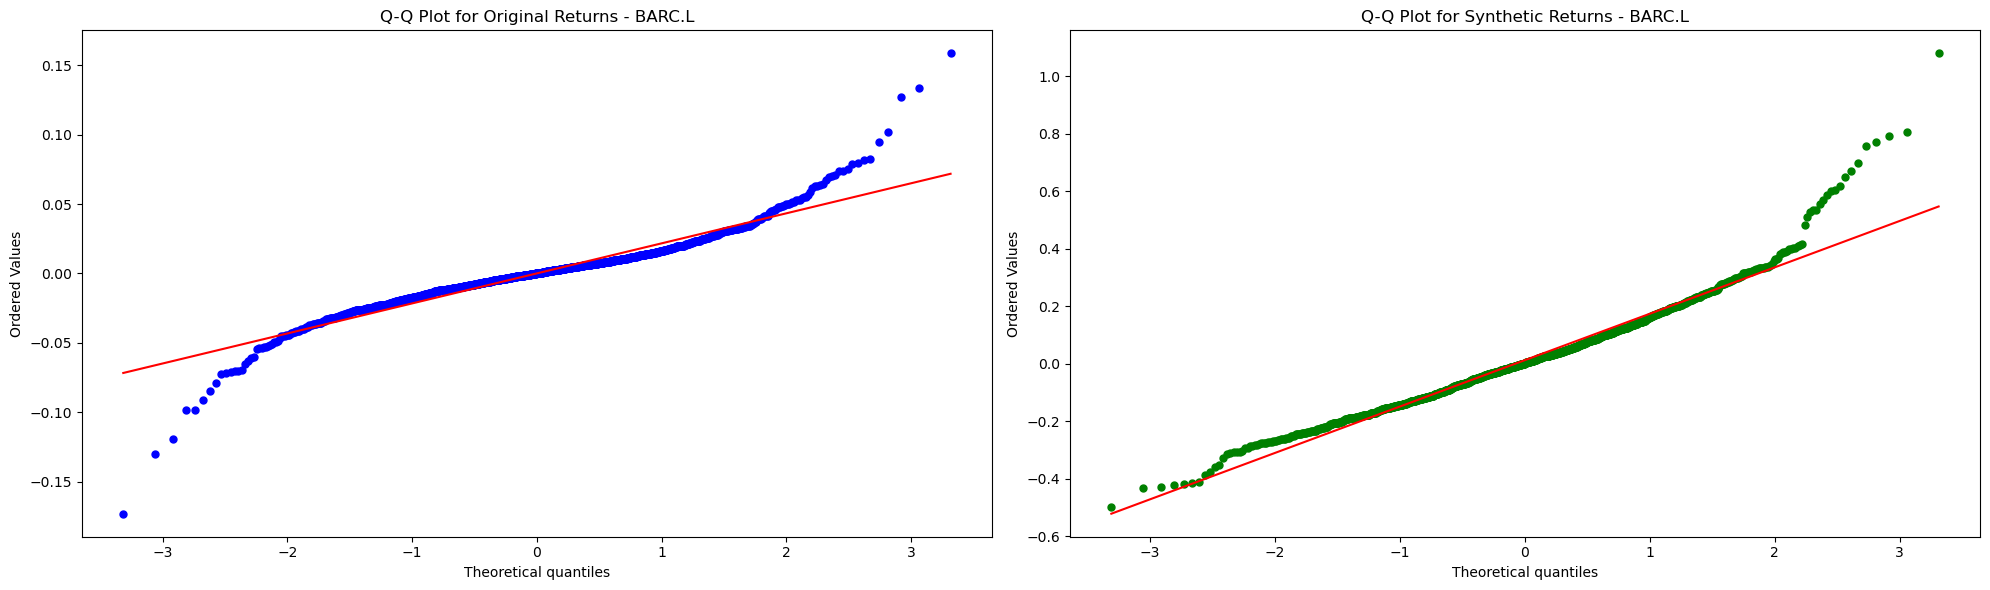


Distributional Analysis for HSBA.L:
K-S Statistic: 0.3665
K-S P-value: 0.0000

Metrics		Original	Synthetic
Skewness:	0.1034		0.6761
Kurtosis:	4.8249		1.6073


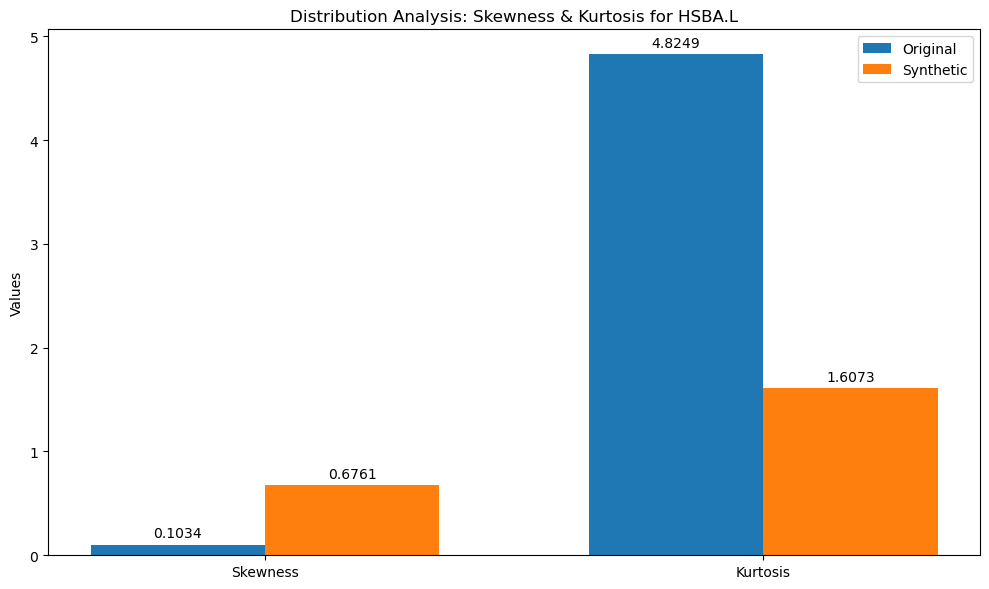

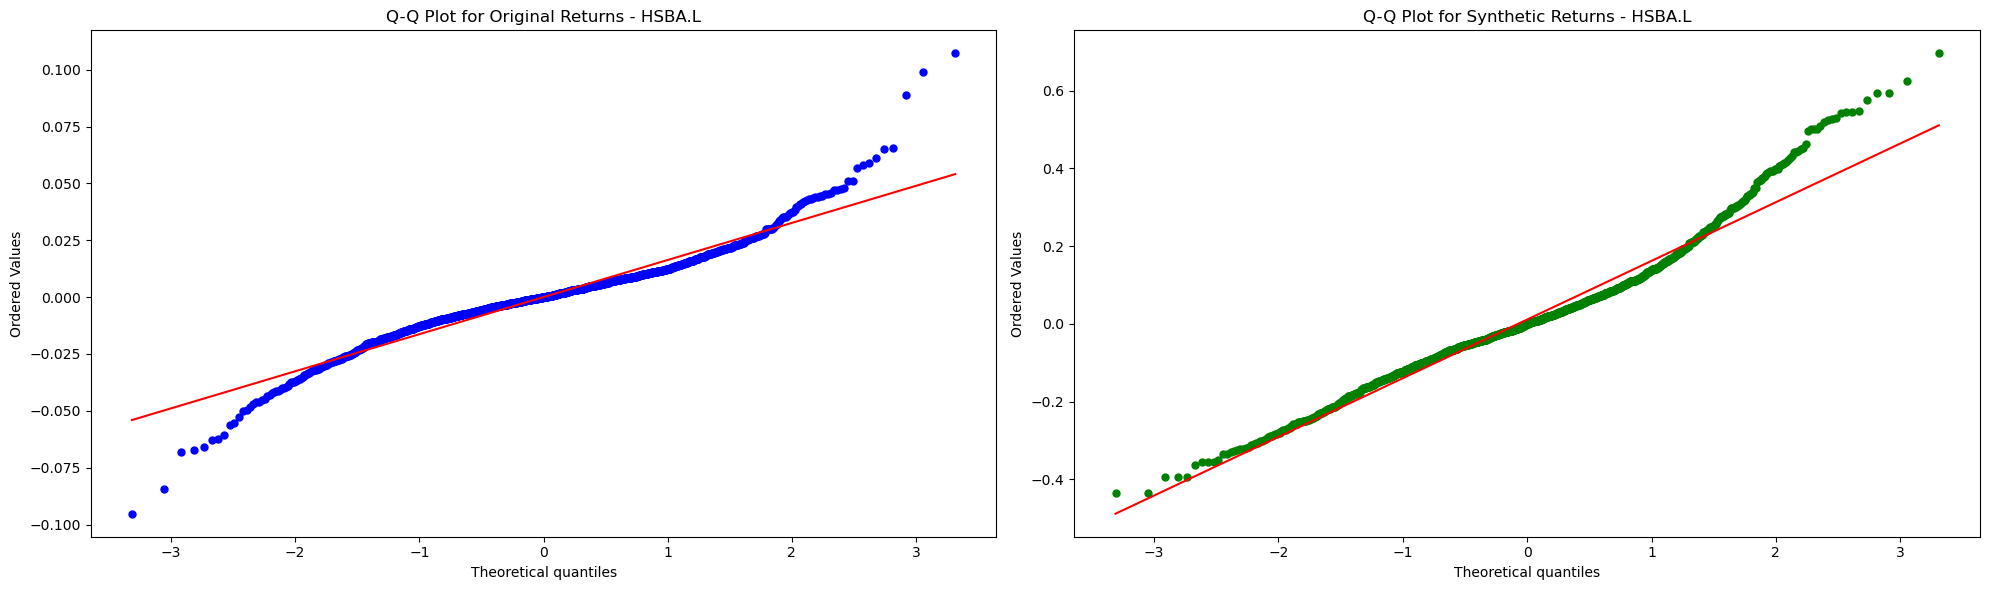


Distributional Analysis for LLOY.L:
K-S Statistic: 0.3971
K-S P-value: 0.0000

Metrics		Original	Synthetic
Skewness:	0.1003		0.5442
Kurtosis:	6.0988		0.5499


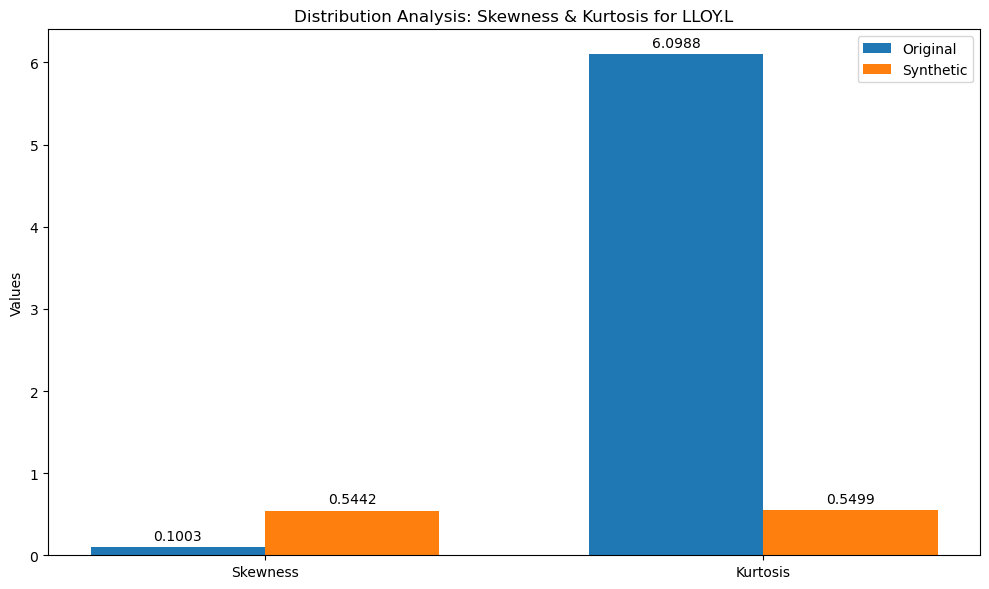

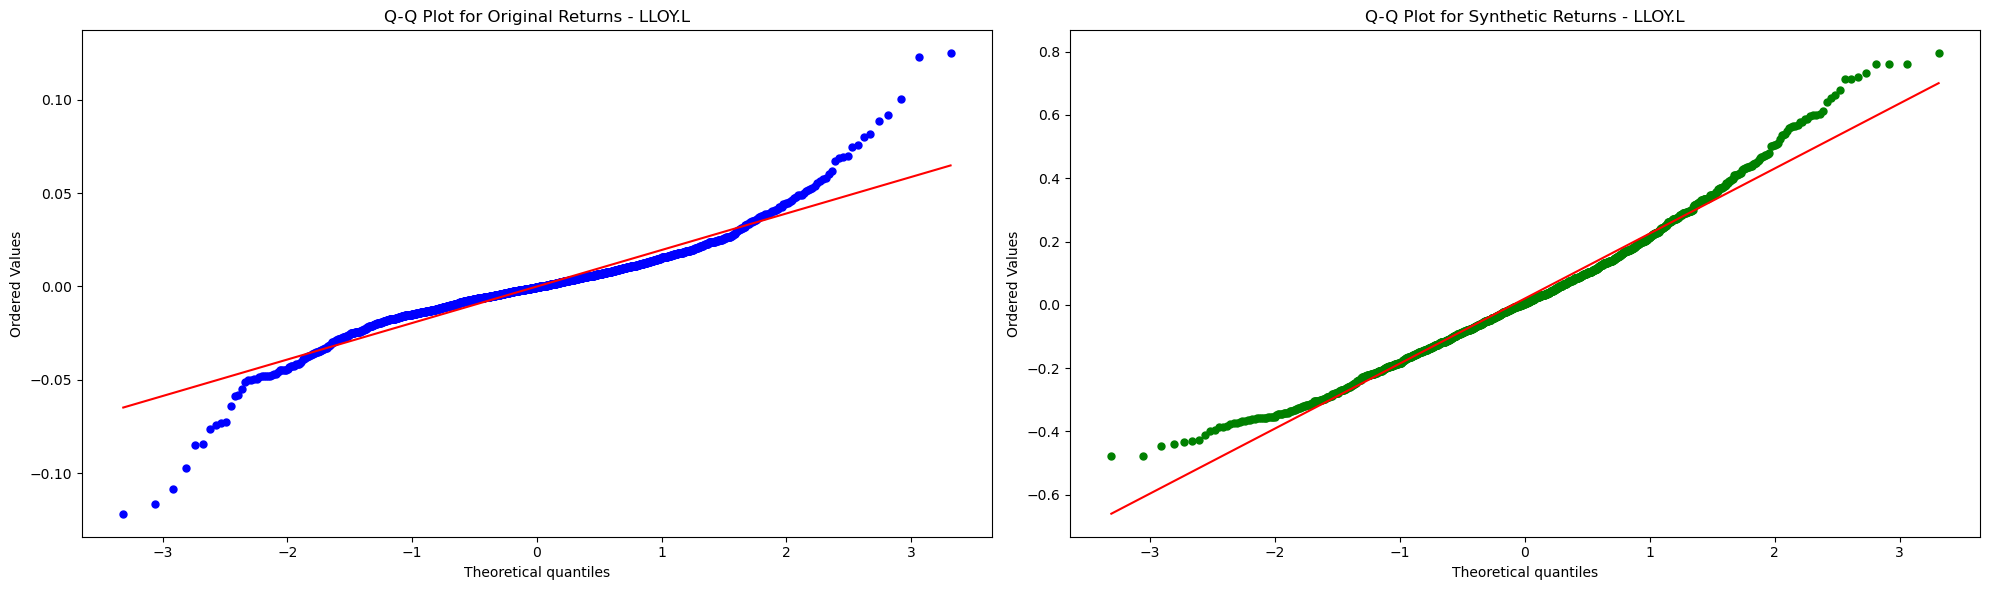


Distributional Analysis for NWG.L:
K-S Statistic: 0.3660
K-S P-value: 0.0000

Metrics		Original	Synthetic
Skewness:	-0.1401		1.1597
Kurtosis:	4.9742		4.0655


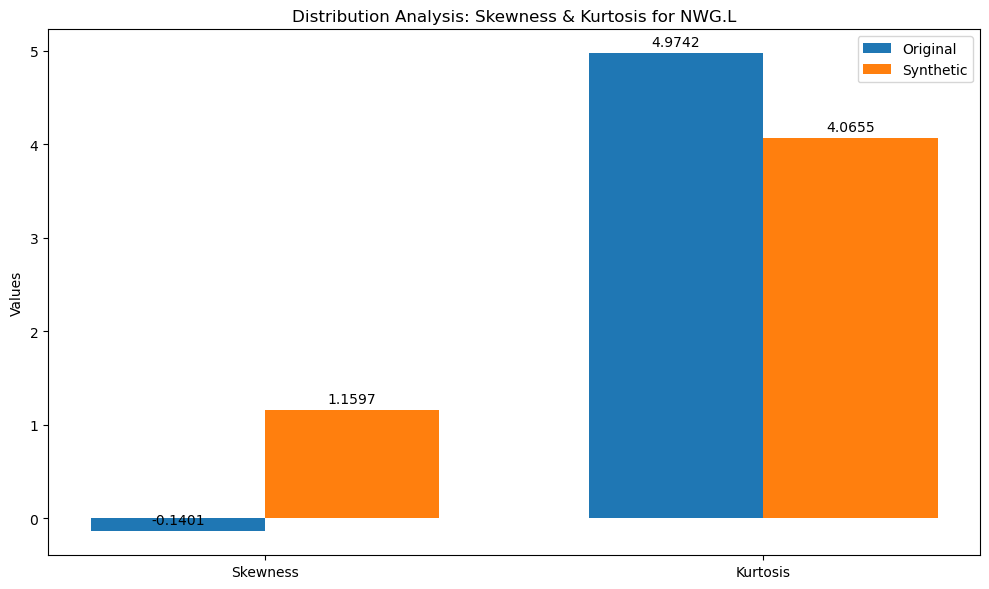

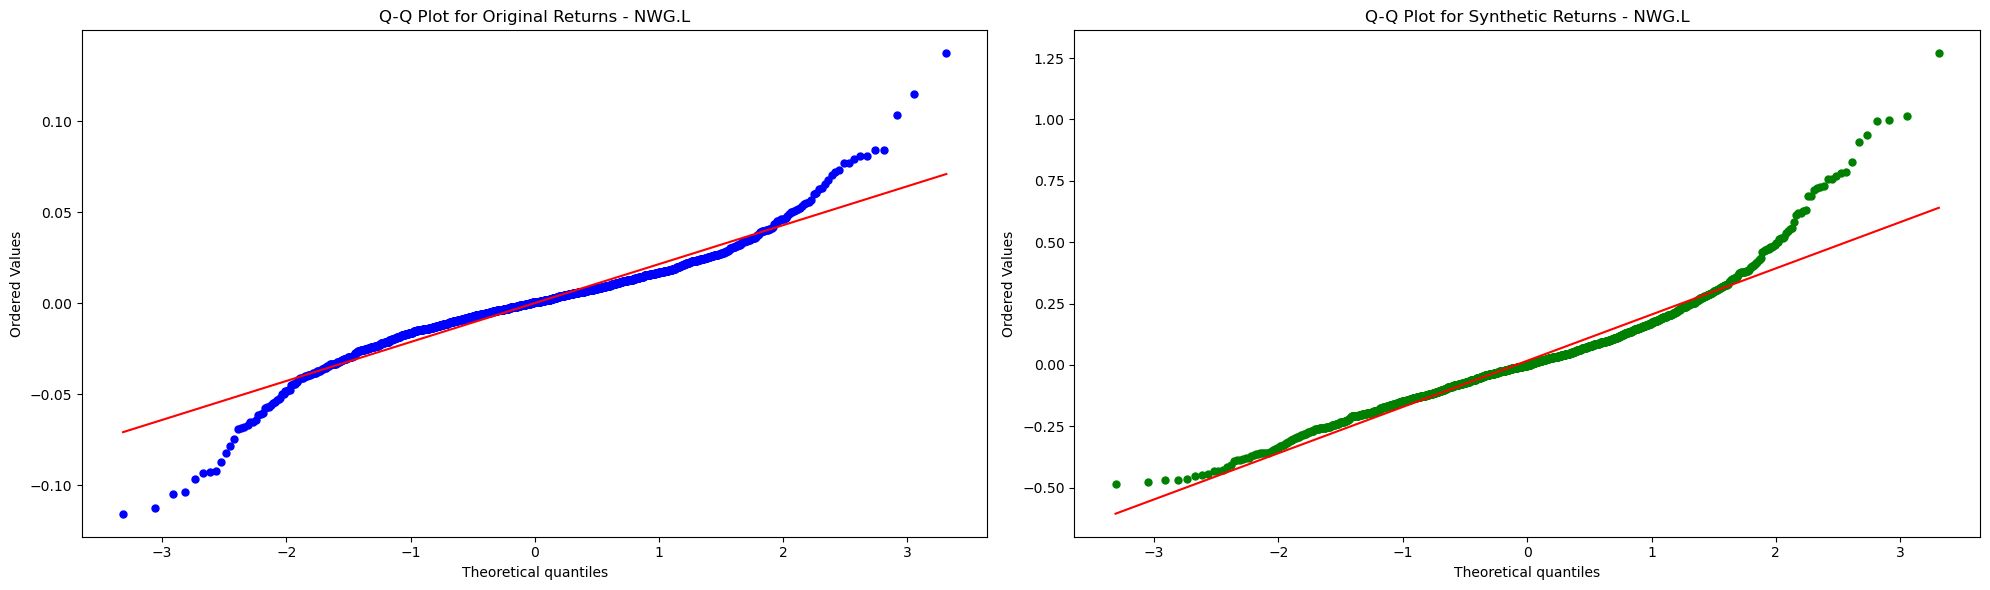


Distributional Analysis for STAN.L:
K-S Statistic: 0.3500
K-S P-value: 0.0000

Metrics		Original	Synthetic
Skewness:	0.1850		0.6114
Kurtosis:	7.4269		1.3579


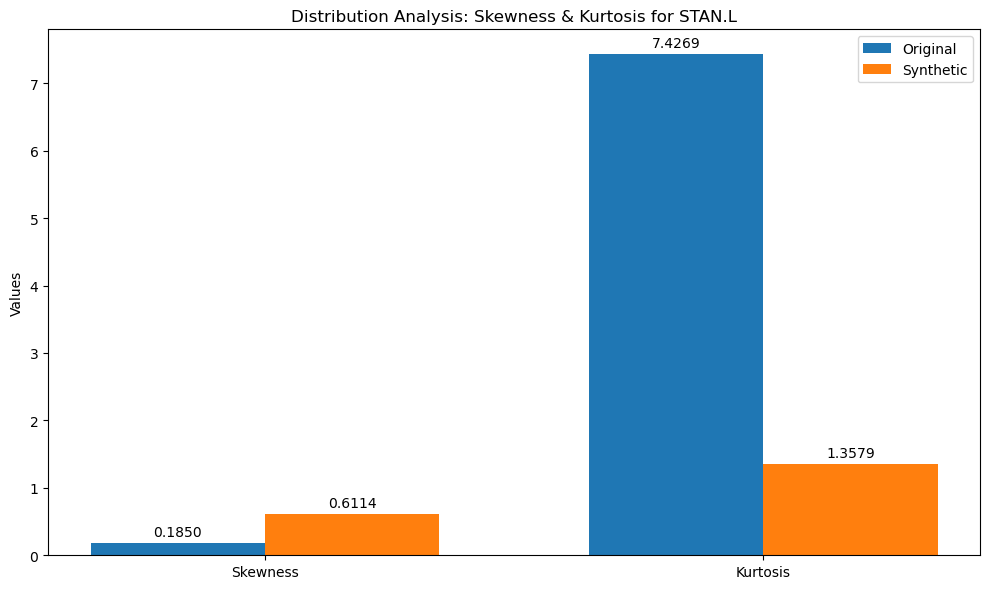

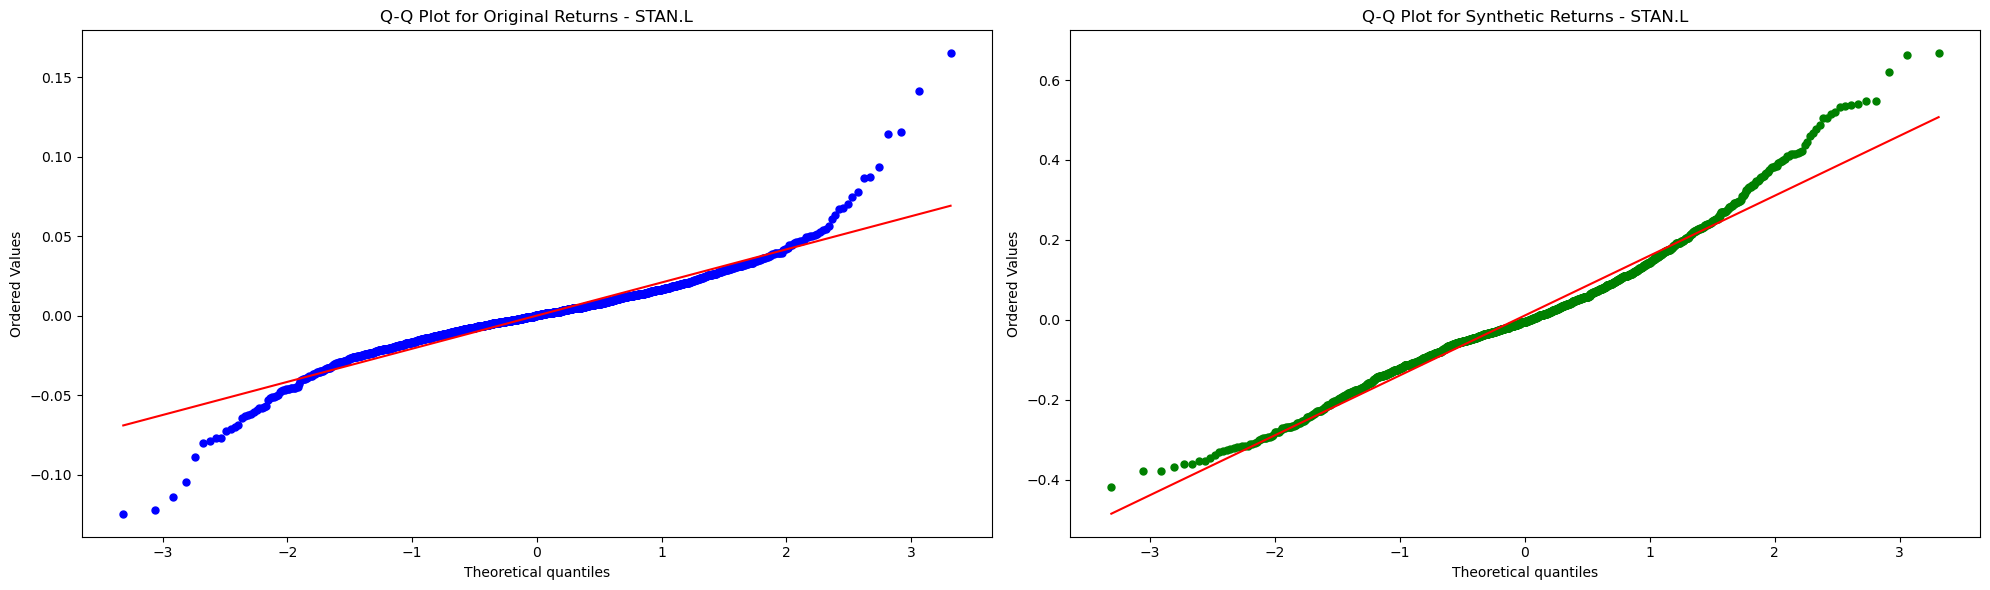

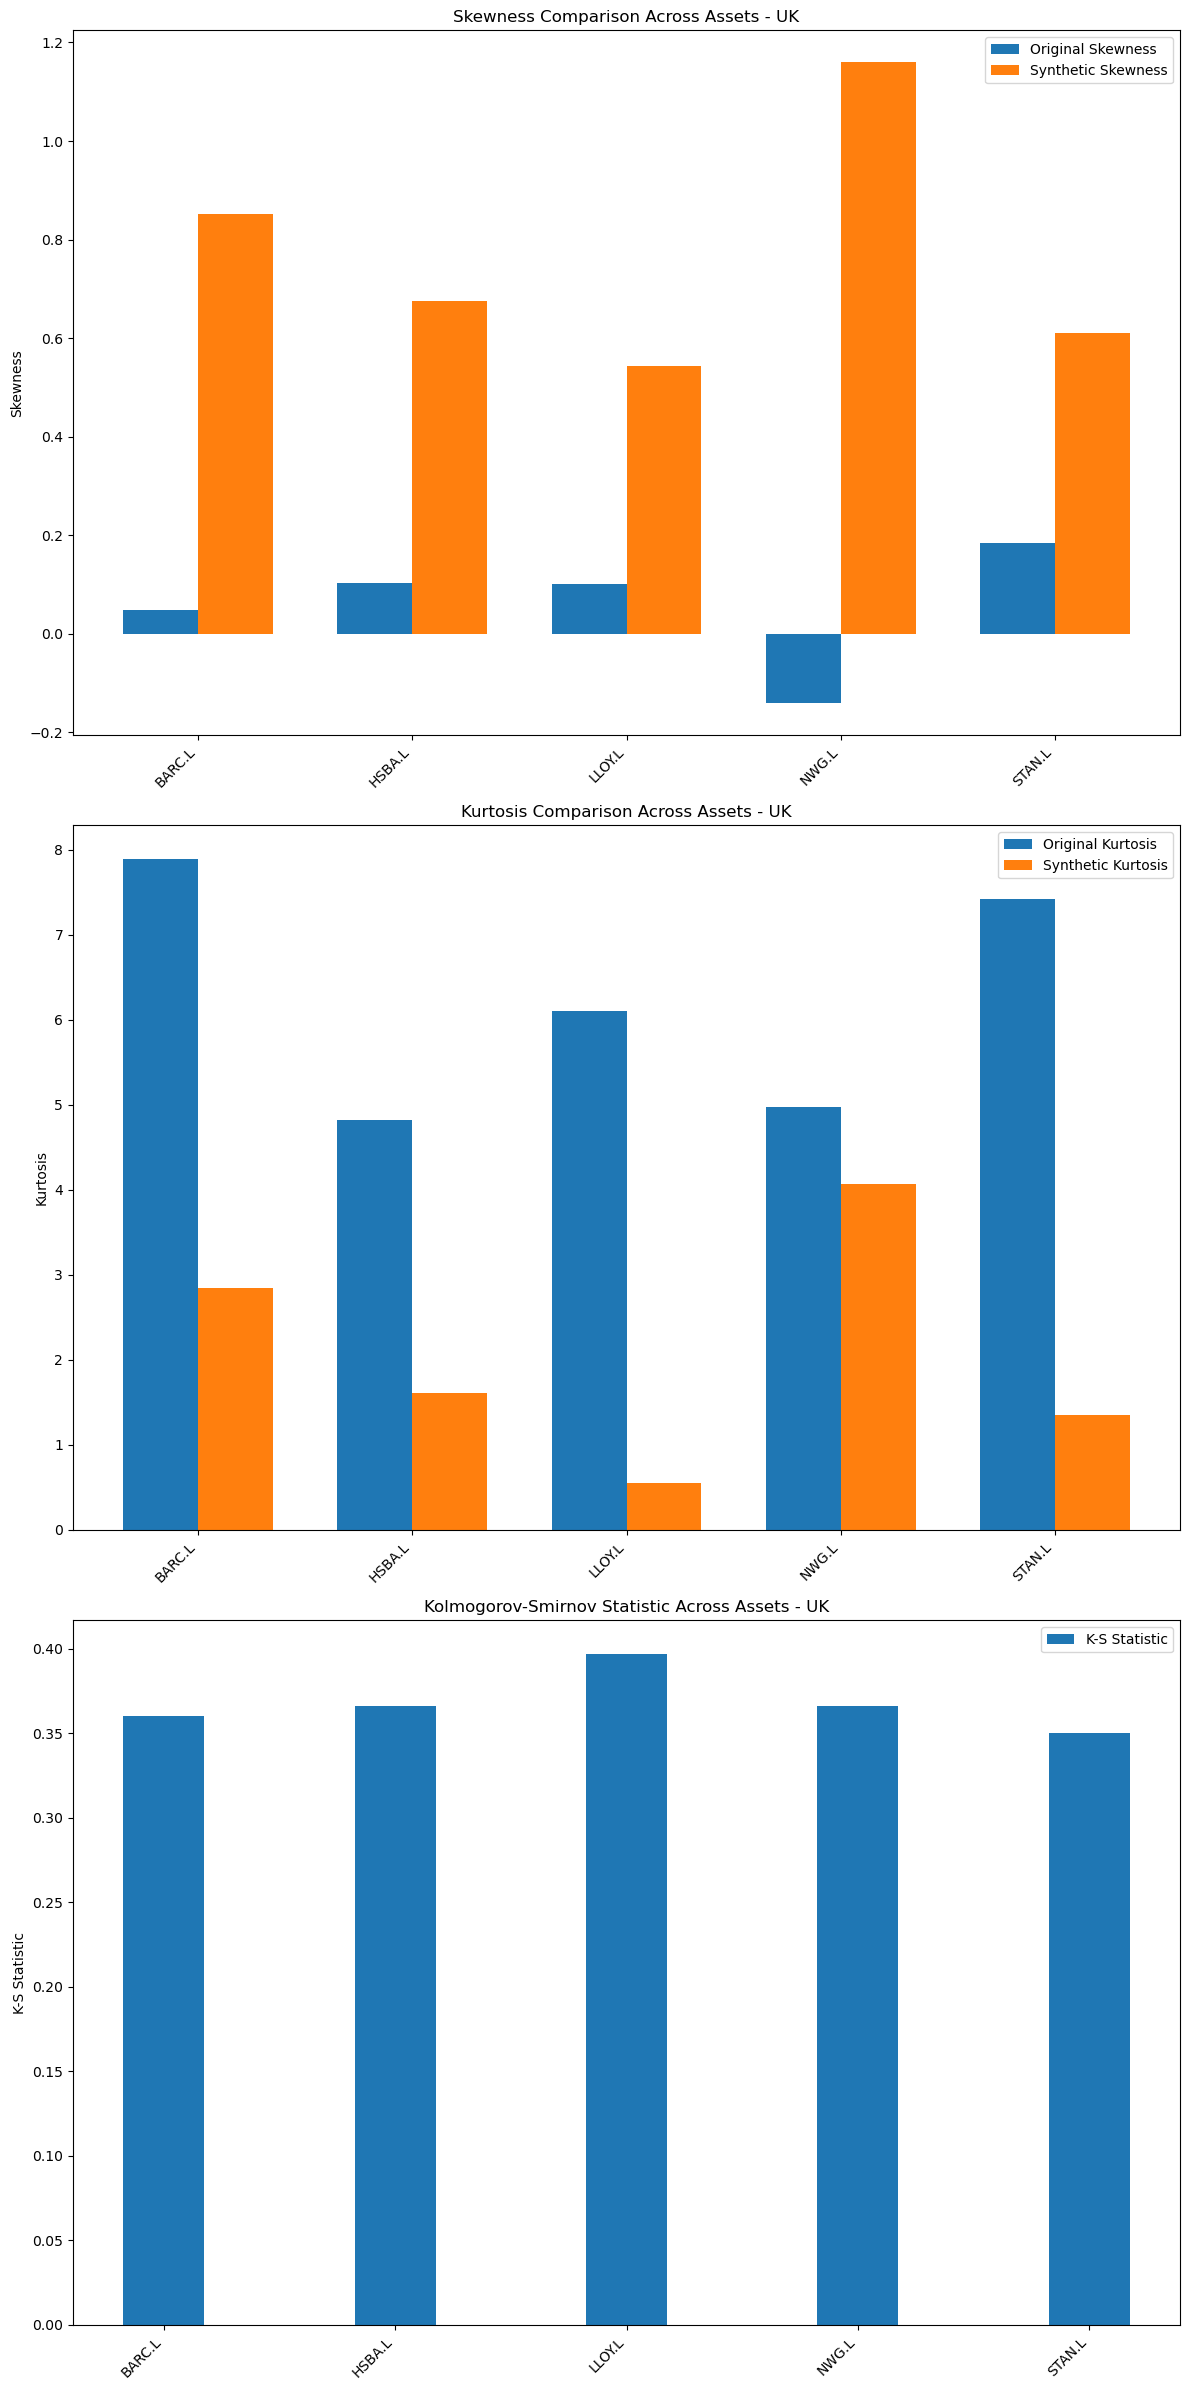


Original Portfolio:

Portfolio Distribution Metrics:
Skewness: 0.0264
Kurtosis: 6.4814


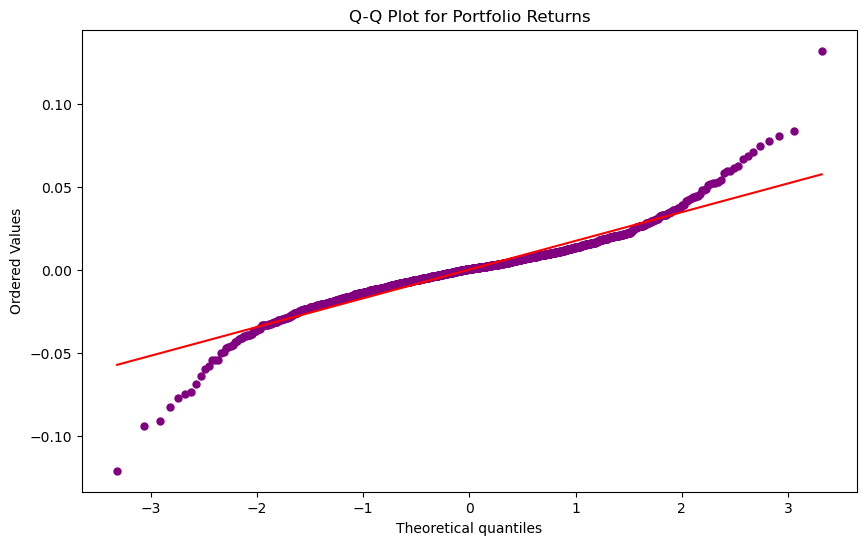


Synthetic Portfolio:

Portfolio Distribution Metrics:
Skewness: 0.7273
Kurtosis: 2.1259


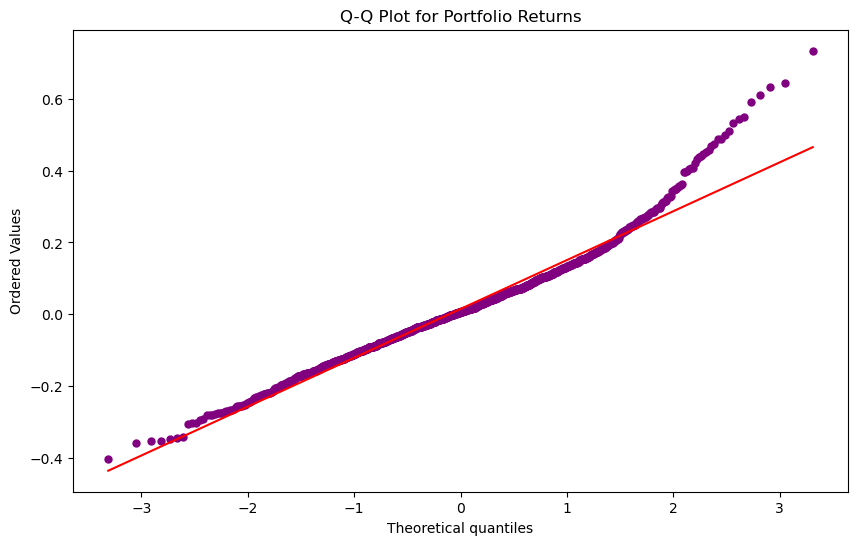

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

def analyze_distribution(original_data, synthetic_data):
    original_returns = original_data.pct_change().dropna()
    synthetic_returns = synthetic_data.pct_change().dropna()

    # Lists to store metrics for aggregate chart
    assets = []
    original_skewness = []
    synthetic_skewness = []
    original_kurtosis = []
    synthetic_kurtosis = []
    ks_statistics = []

    for column in original_returns.columns:
        # K-S Test
        ks_statistic, ks_pvalue = stats.ks_2samp(original_returns[column], synthetic_returns[column])

        # Skewness and Kurtosis
        orig_skew = stats.skew(original_returns[column])
        synth_skew = stats.skew(synthetic_returns[column])
        orig_kurt = stats.kurtosis(original_returns[column])
        synth_kurt = stats.kurtosis(synthetic_returns[column])

        # Store metrics for aggregate chart
        assets.append(column)
        original_skewness.append(orig_skew)
        synthetic_skewness.append(synth_skew)
        original_kurtosis.append(orig_kurt)
        synthetic_kurtosis.append(synth_kurt)
        ks_statistics.append(ks_statistic)

        # Print Results
        print(f"\nDistributional Analysis for {column}:")
        print(f"K-S Statistic: {ks_statistic:.4f}")
        print(f"K-S P-value: {ks_pvalue:.4f}")
        print("\nMetrics\t\tOriginal\tSynthetic")
        print(f"Skewness:\t{orig_skew:.4f}\t\t{synth_skew:.4f}")
        print(f"Kurtosis:\t{orig_kurt:.4f}\t\t{synth_kurt:.4f}")

        # Individual asset visualization
        labels = ['Skewness', 'Kurtosis']
        original_metrics = [orig_skew, orig_kurt]
        synthetic_metrics = [synth_skew, synth_kurt]

        x = np.arange(len(labels))
        width = 0.35

        fig, ax = plt.subplots(figsize=(10, 6))
        rects1 = ax.bar(x - width/2, original_metrics, width, label='Original')
        rects2 = ax.bar(x + width/2, synthetic_metrics, width, label='Synthetic')

        ax.set_ylabel('Values')
        ax.set_title(f'Distribution Analysis: Skewness & Kurtosis for {column}')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()

        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.4f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')

        autolabel(rects1)
        autolabel(rects2)

        plt.tight_layout()
        plt.show()

        # Q-Q plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
        
        stats.probplot(original_returns[column], dist="norm", plot=ax1, fit=True)
        ax1.get_lines()[0].set_markerfacecolor('blue')
        ax1.get_lines()[0].set_markeredgecolor('blue')
        ax1.get_lines()[0].set_markersize(5)
        ax1.get_lines()[1].set_color('red')
        ax1.set_title(f'Q-Q Plot for Original Returns - {column}')

        stats.probplot(synthetic_returns[column], dist="norm", plot=ax2, fit=True)
        ax2.get_lines()[0].set_markerfacecolor('green')
        ax2.get_lines()[0].set_markeredgecolor('green')
        ax2.get_lines()[0].set_markersize(5)
        ax2.get_lines()[1].set_color('red')
        ax2.set_title(f'Q-Q Plot for Synthetic Returns - {column}')

        plt.tight_layout()
        plt.show()

    # Aggregate charts
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 24))
    x = np.arange(len(assets))
    width = 0.35

    # Skewness comparison
    ax1.bar(x - width/2, original_skewness, width, label='Original Skewness')
    ax1.bar(x + width/2, synthetic_skewness, width, label='Synthetic Skewness')
    ax1.set_ylabel('Skewness')
    ax1.set_title('Skewness Comparison Across Assets - UK')
    ax1.set_xticks(x)
    ax1.set_xticklabels(assets, rotation=45, ha='right')
    ax1.legend()

    # Kurtosis comparison
    ax2.bar(x - width/2, original_kurtosis, width, label='Original Kurtosis')
    ax2.bar(x + width/2, synthetic_kurtosis, width, label='Synthetic Kurtosis')
    ax2.set_ylabel('Kurtosis')
    ax2.set_title('Kurtosis Comparison Across Assets - UK')
    ax2.set_xticks(x)
    ax2.set_xticklabels(assets, rotation=45, ha='right')
    ax2.legend()

    # K-S statistic comparison
    ax3.bar(x, ks_statistics, width, label='K-S Statistic')
    ax3.set_ylabel('K-S Statistic')
    ax3.set_title('Kolmogorov-Smirnov Statistic Across Assets - UK')
    ax3.set_xticks(x)
    ax3.set_xticklabels(assets, rotation=45, ha='right')
    ax3.legend()

    plt.tight_layout()
    plt.show()

def analyze_portfolio_distribution(data, weights=None):
    if weights is None:
        weights = np.ones(len(data.columns)) / len(data.columns)  # Equal weights if not provided
    
    portfolio_returns = (data.pct_change().dropna() * weights).sum(axis=1)
    
    print("\nPortfolio Distribution Metrics:")
    print(f"Skewness: {stats.skew(portfolio_returns):.4f}")
    print(f"Kurtosis: {stats.kurtosis(portfolio_returns):.4f}")
    
    # Q-Q plot for portfolio
    fig, ax = plt.subplots(figsize=(10, 6))
    stats.probplot(portfolio_returns, dist="norm", plot=ax, fit=True)
    ax.get_lines()[0].set_markerfacecolor('purple')
    ax.get_lines()[0].set_markeredgecolor('purple')
    ax.get_lines()[0].set_markersize(5)
    ax.get_lines()[1].set_color('red')
    ax.set_title('Q-Q Plot for Portfolio Returns')
    plt.show()

# Assuming stock_data and rescaled_synthetic_data are available
# If they're not, you might need to load or recreate them here

# Perform the distributional analysis
analyze_distribution(stock_data, rescaled_synthetic_data)

print("\nOriginal Portfolio:")
analyze_portfolio_distribution(stock_data)

print("\nSynthetic Portfolio:")
analyze_portfolio_distribution(rescaled_synthetic_data)

# Spectral Analysis

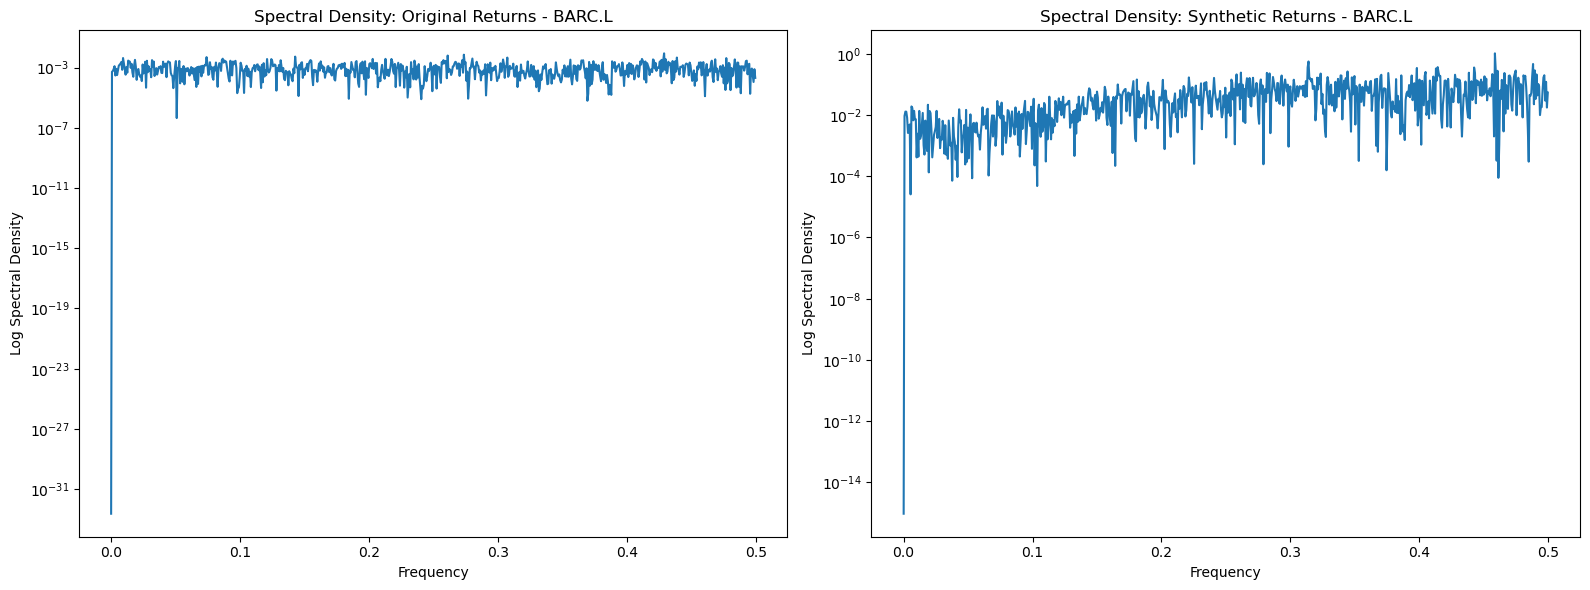


Spectral Analysis for BARC.L:
Original Returns - Spectral Density Statistics:
Max: 0.00876
Min: 0.00000
Mean: 0.00102
Median: 0.00072
Standard Deviation: 0.00100

Synthetic Returns - Spectral Density Statistics:
Max: 1.03158
Min: 0.00000
Mean: 0.05380
Median: 0.02633
Standard Deviation: 0.07624


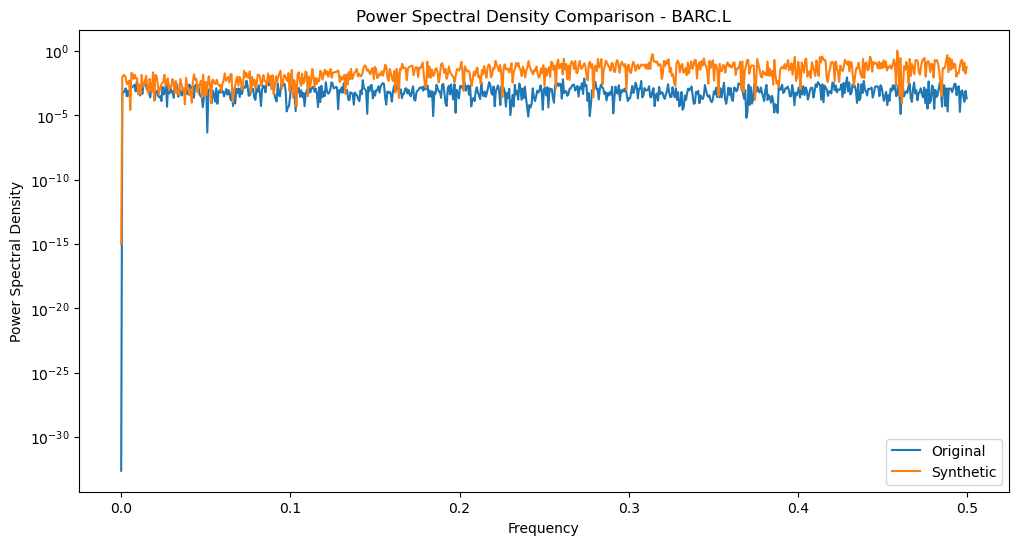

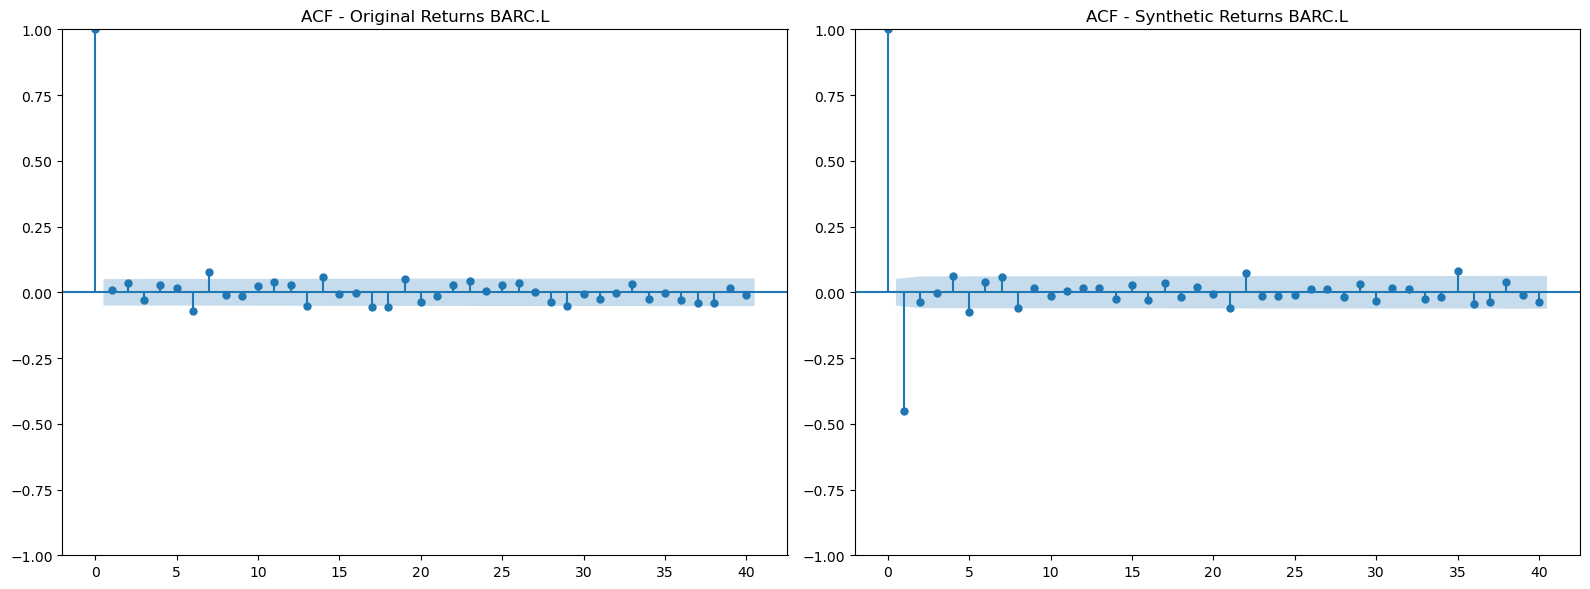

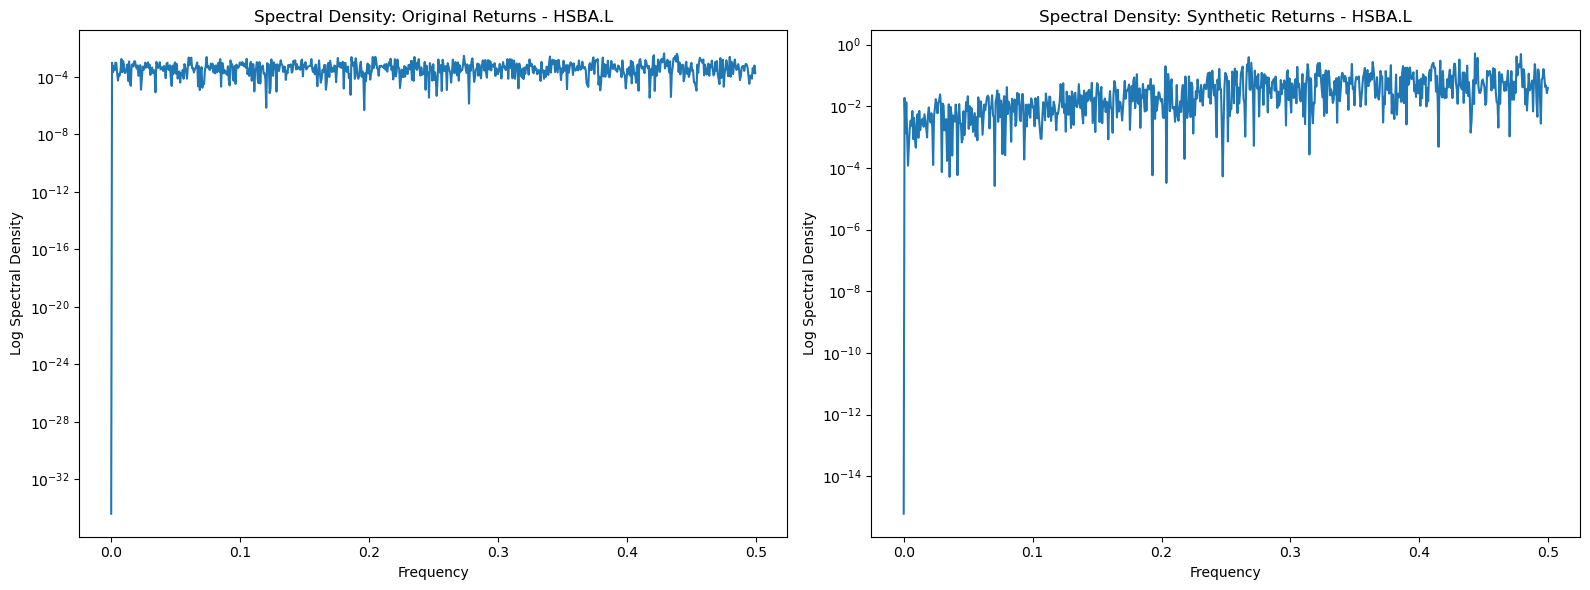


Spectral Analysis for HSBA.L:
Original Returns - Spectral Density Statistics:
Max: 0.00429
Min: 0.00000
Mean: 0.00056
Median: 0.00041
Standard Deviation: 0.00056

Synthetic Returns - Spectral Density Statistics:
Max: 0.51976
Min: 0.00000
Mean: 0.04689
Median: 0.02165
Standard Deviation: 0.06298


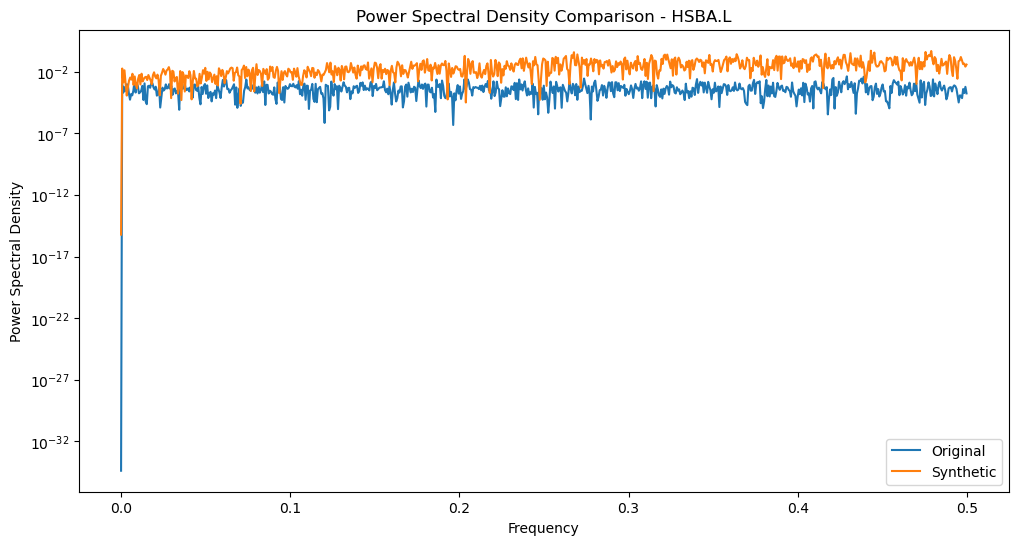

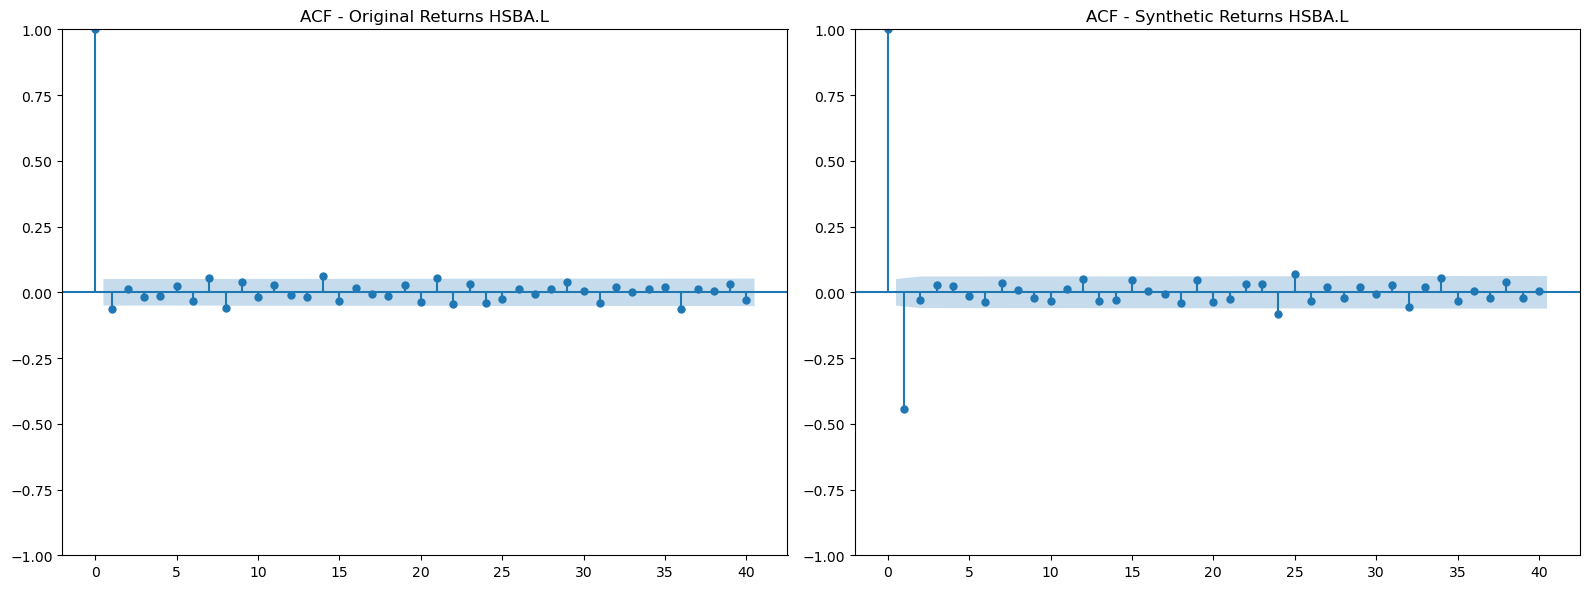

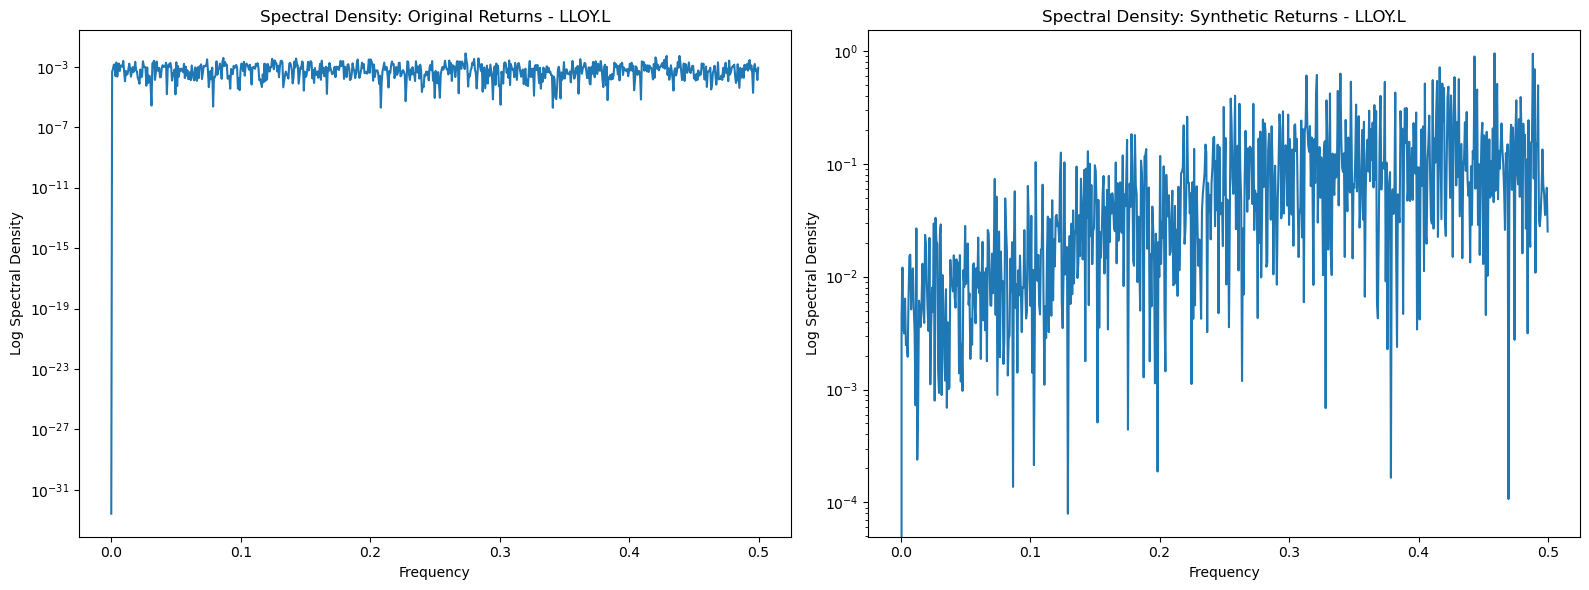


Spectral Analysis for LLOY.L:
Original Returns - Spectral Density Statistics:
Max: 0.00778
Min: 0.00000
Mean: 0.00083
Median: 0.00058
Standard Deviation: 0.00081

Synthetic Returns - Spectral Density Statistics:
Max: 0.95147
Min: 0.00000
Mean: 0.08556
Median: 0.03873
Standard Deviation: 0.12404


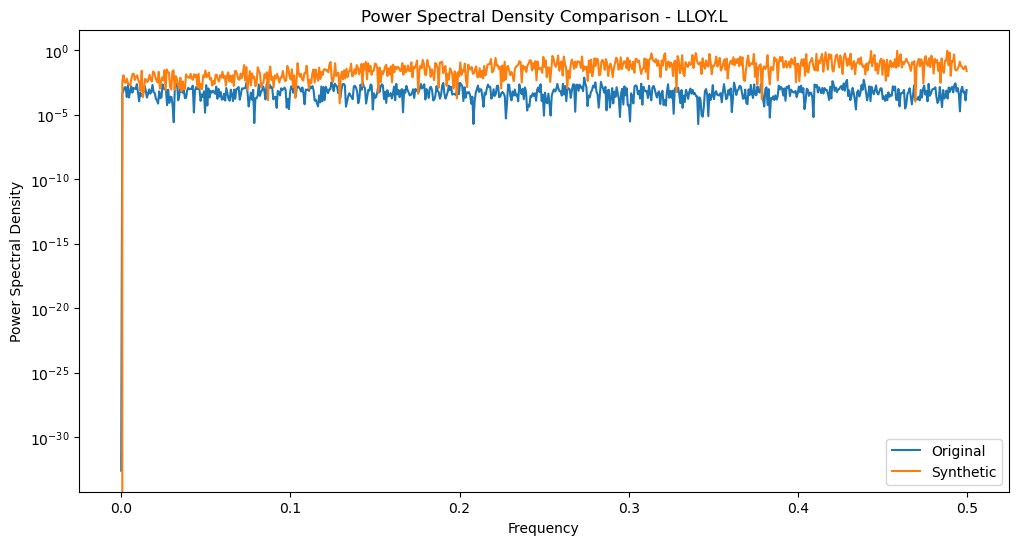

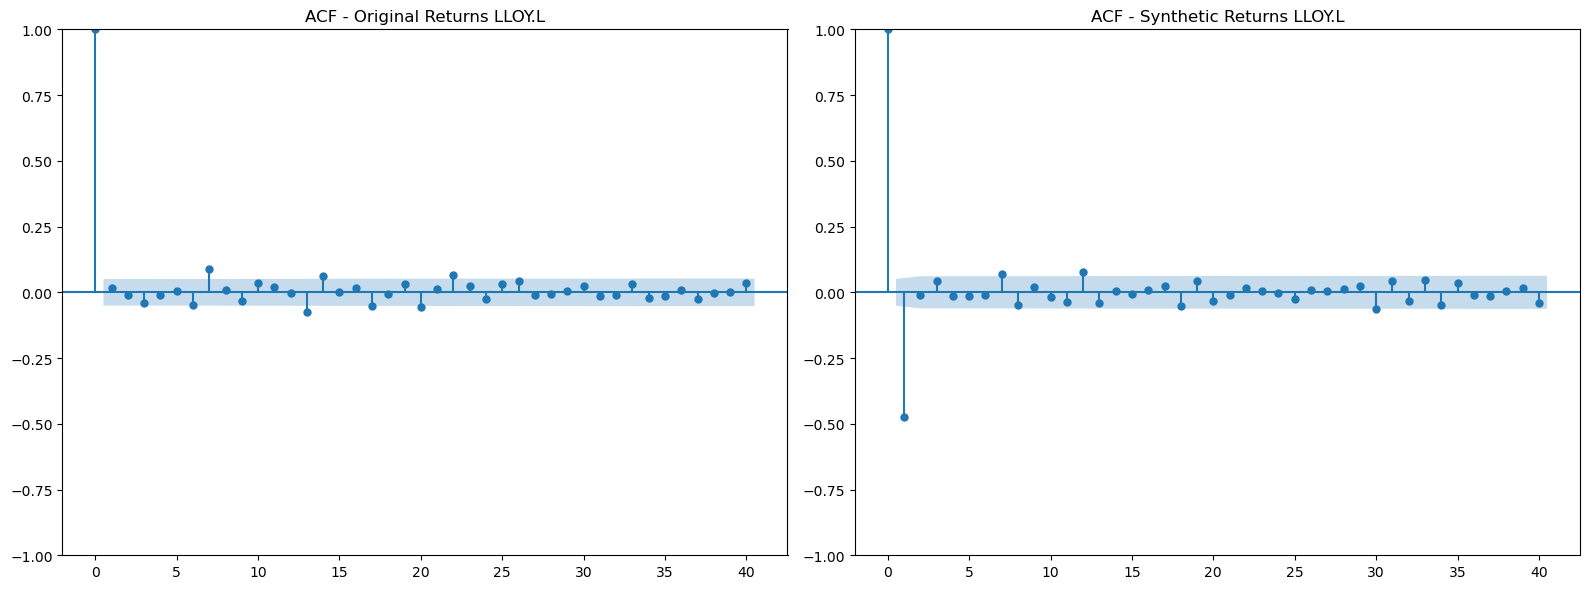

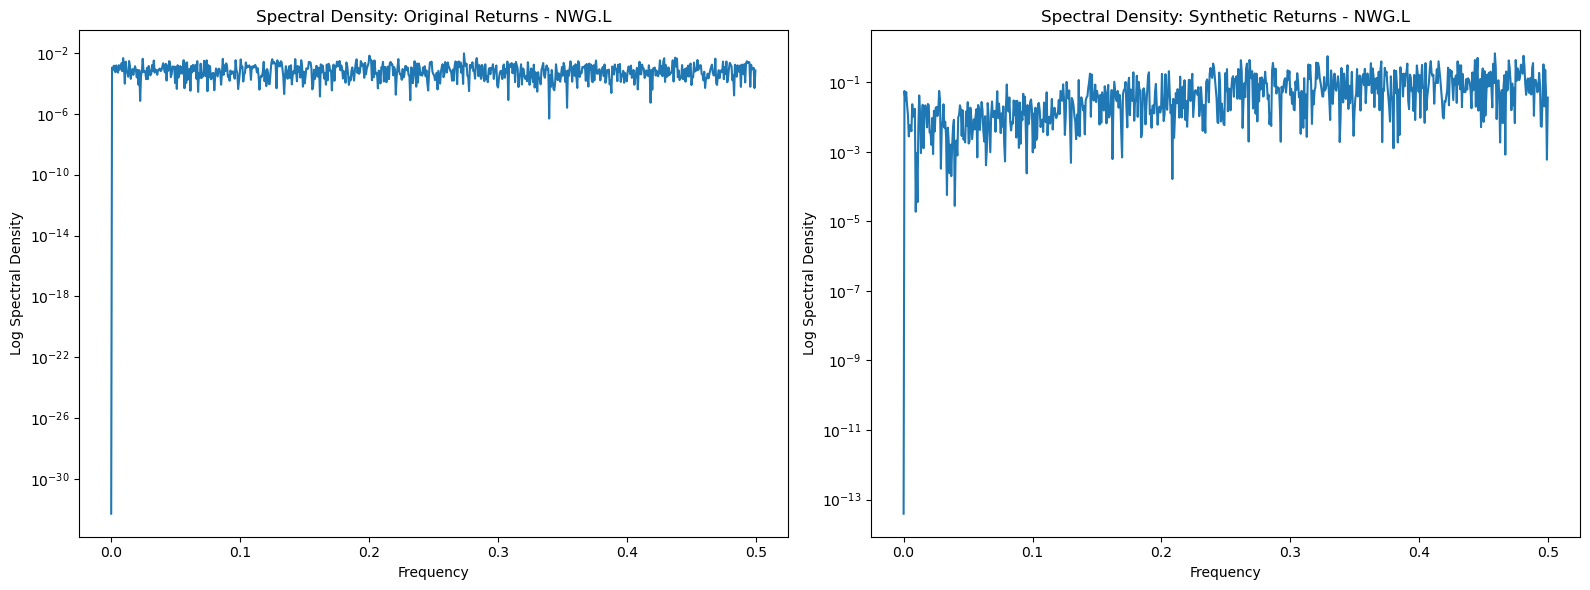


Spectral Analysis for NWG.L:
Original Returns - Spectral Density Statistics:
Max: 0.00952
Min: 0.00000
Mean: 0.00098
Median: 0.00066
Standard Deviation: 0.00098

Synthetic Returns - Spectral Density Statistics:
Max: 0.68082
Min: 0.00000
Mean: 0.07531
Median: 0.03840
Standard Deviation: 0.09517


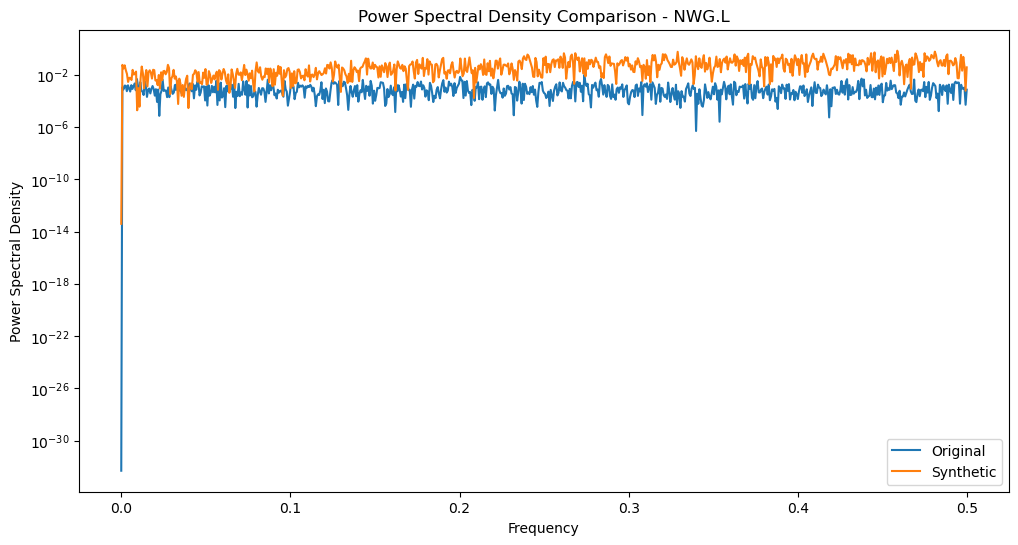

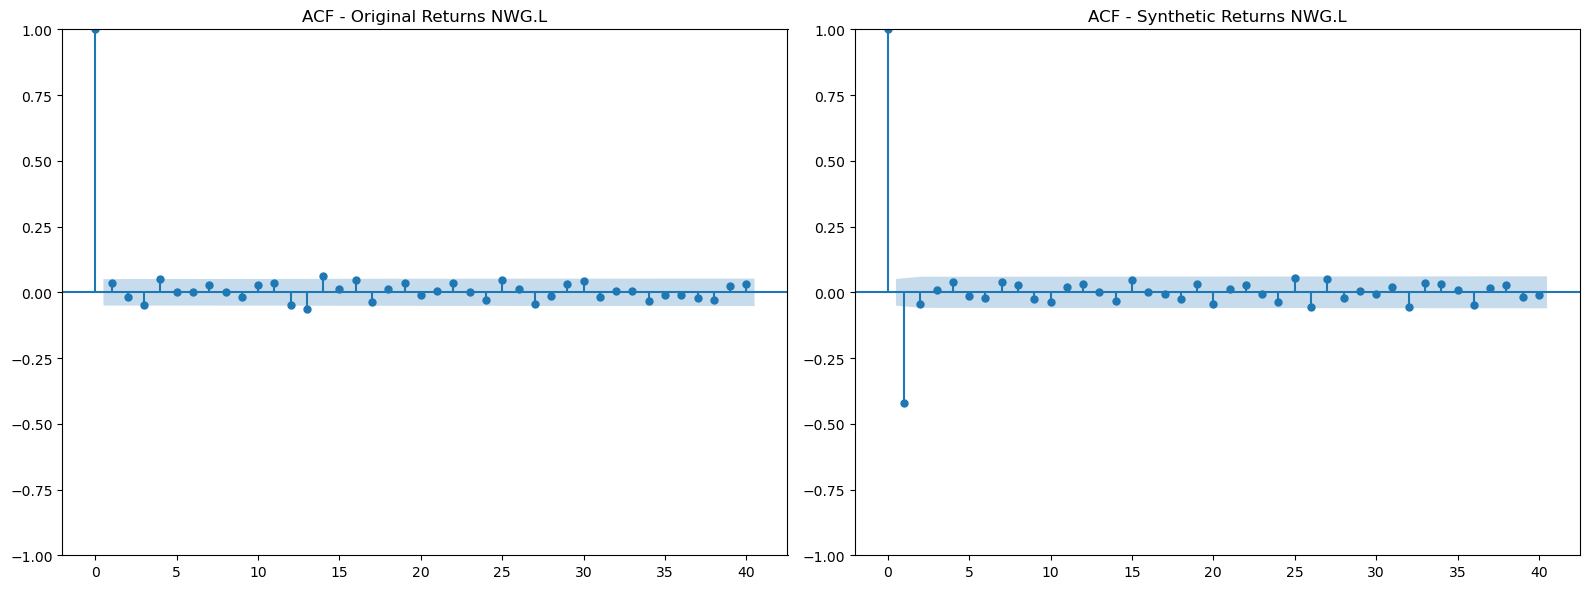

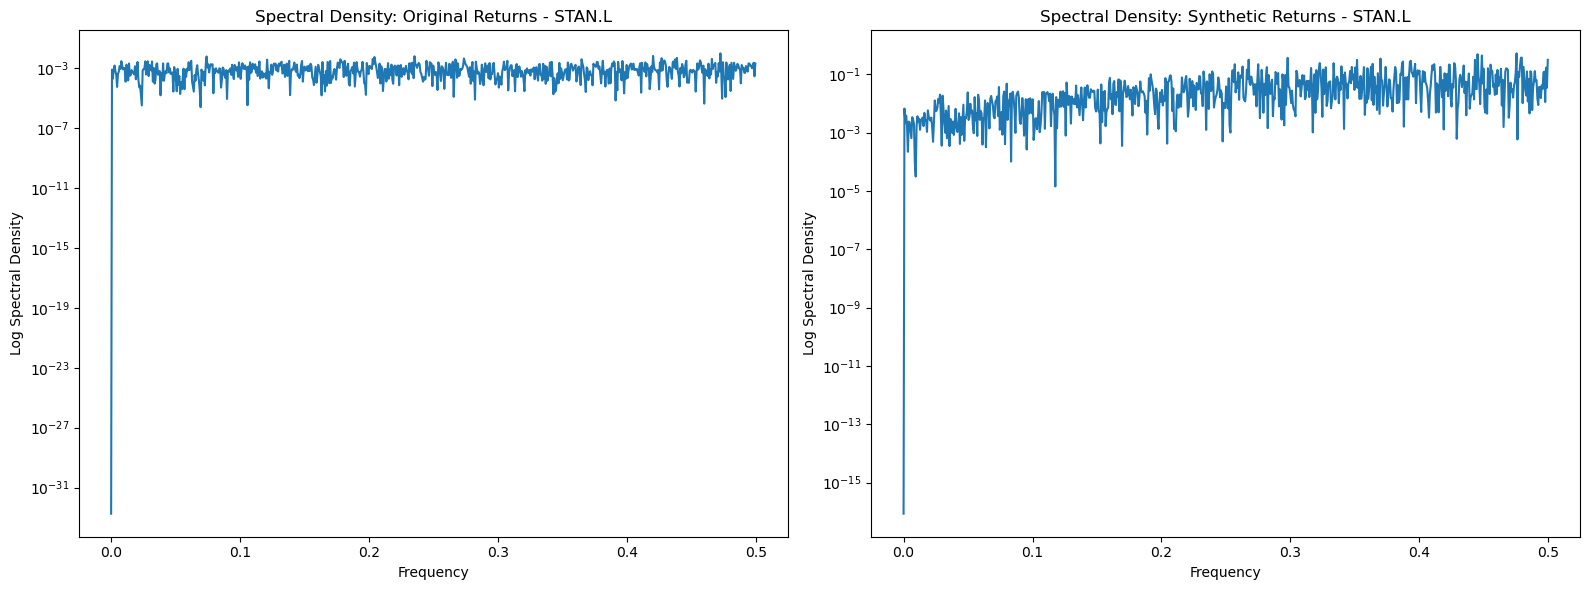


Spectral Analysis for STAN.L:
Original Returns - Spectral Density Statistics:
Max: 0.00920
Min: 0.00000
Mean: 0.00094
Median: 0.00066
Standard Deviation: 0.00094

Synthetic Returns - Spectral Density Statistics:
Max: 0.52265
Min: 0.00000
Mean: 0.04596
Median: 0.02112
Standard Deviation: 0.06581


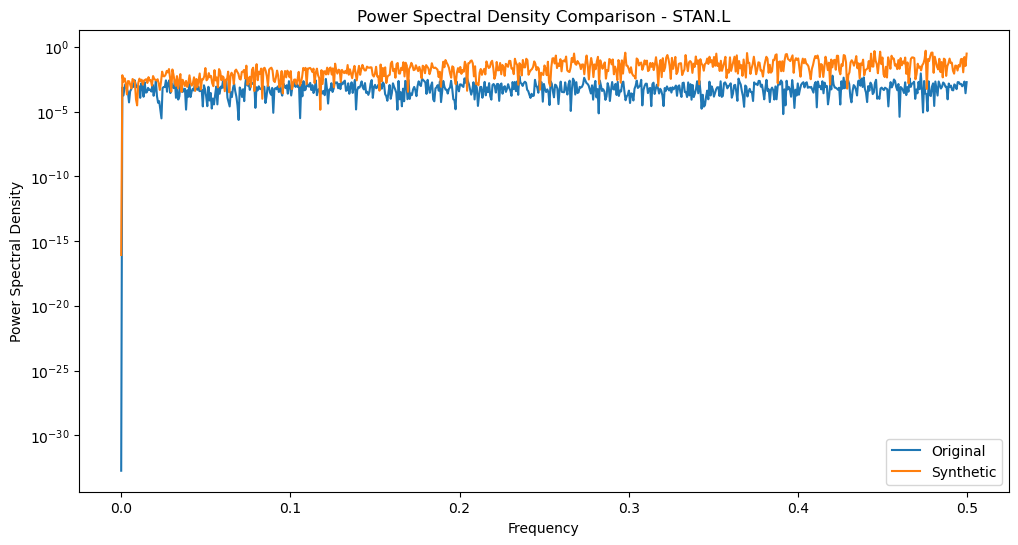

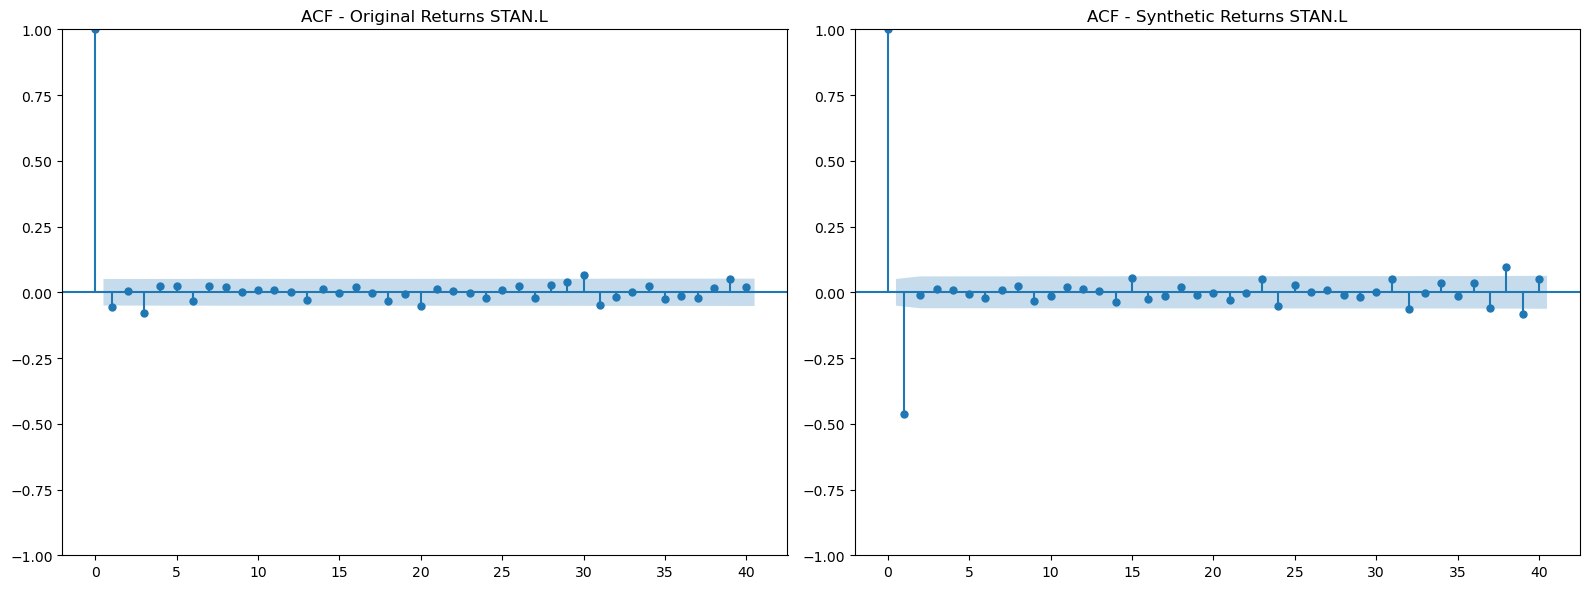

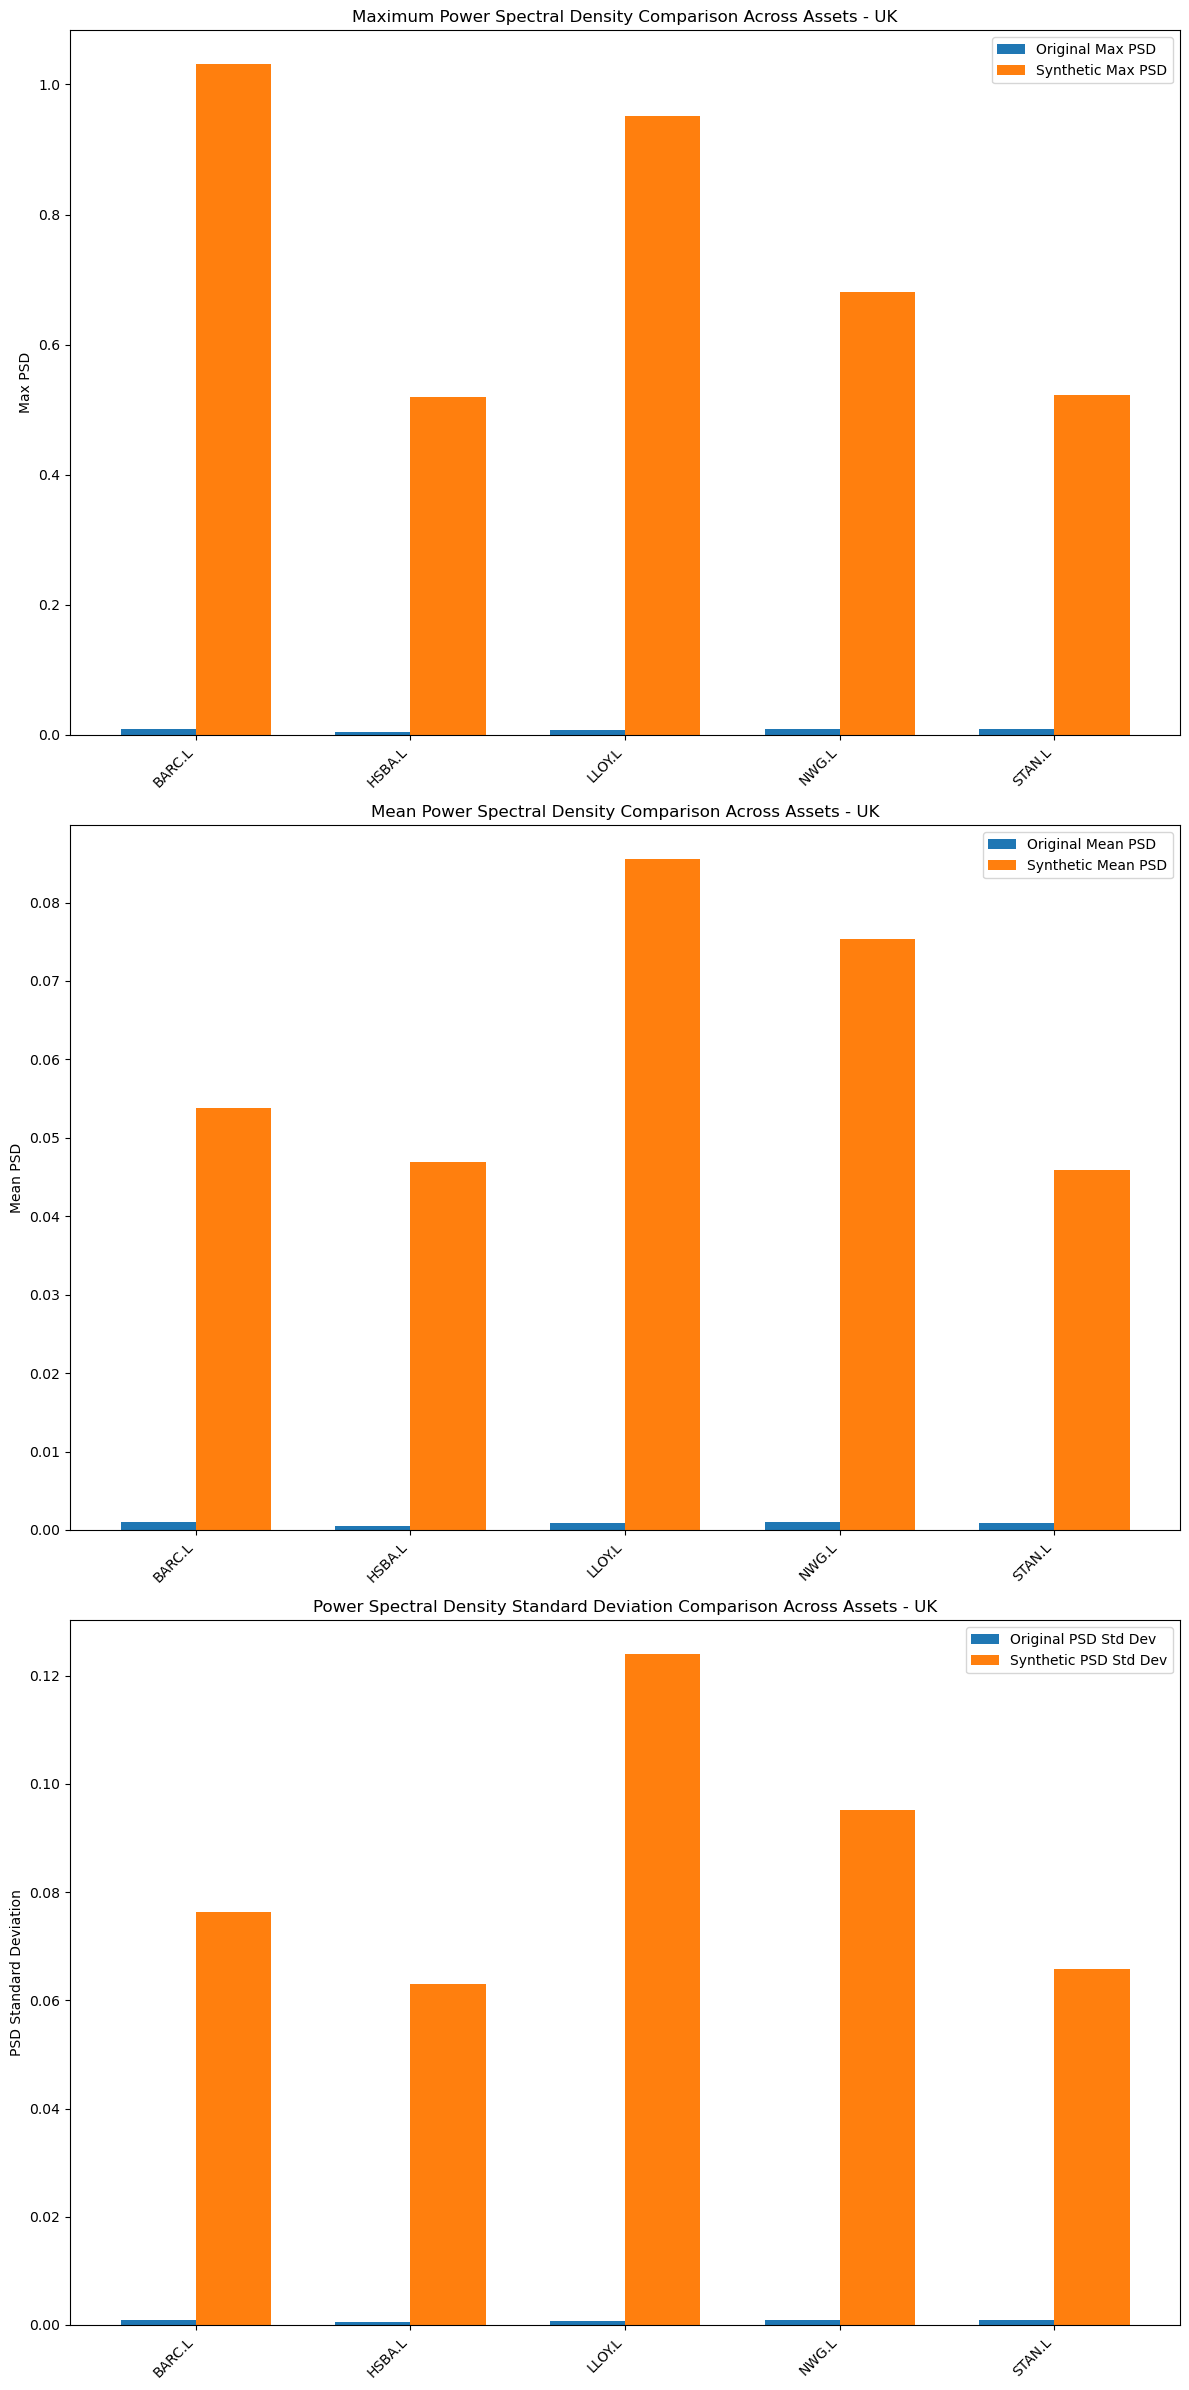


Original Portfolio:


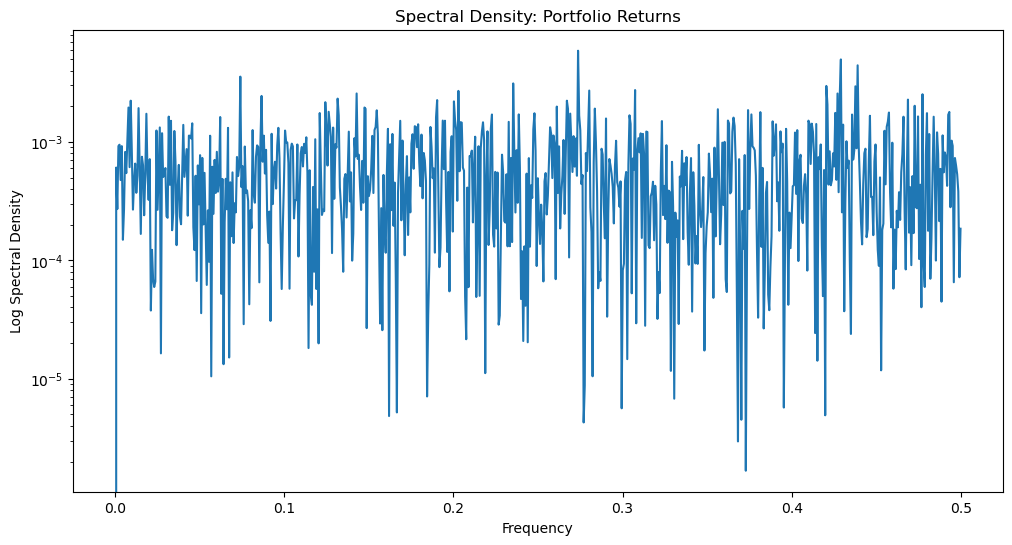


Portfolio Spectral Density Statistics:
Max: 0.00589
Min: 0.00000
Mean: 0.00064
Median: 0.00049
Standard Deviation: 0.00064


<Figure size 1200x600 with 0 Axes>

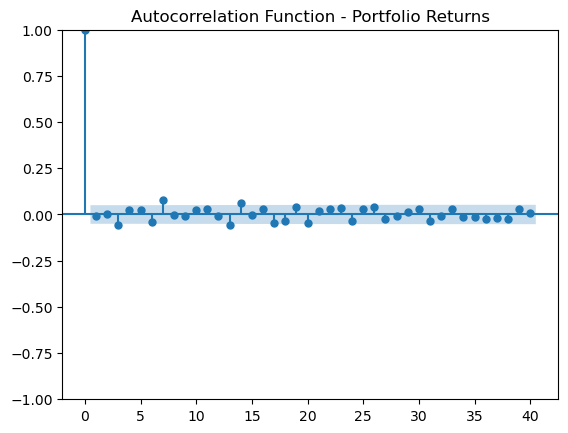


Synthetic Portfolio:


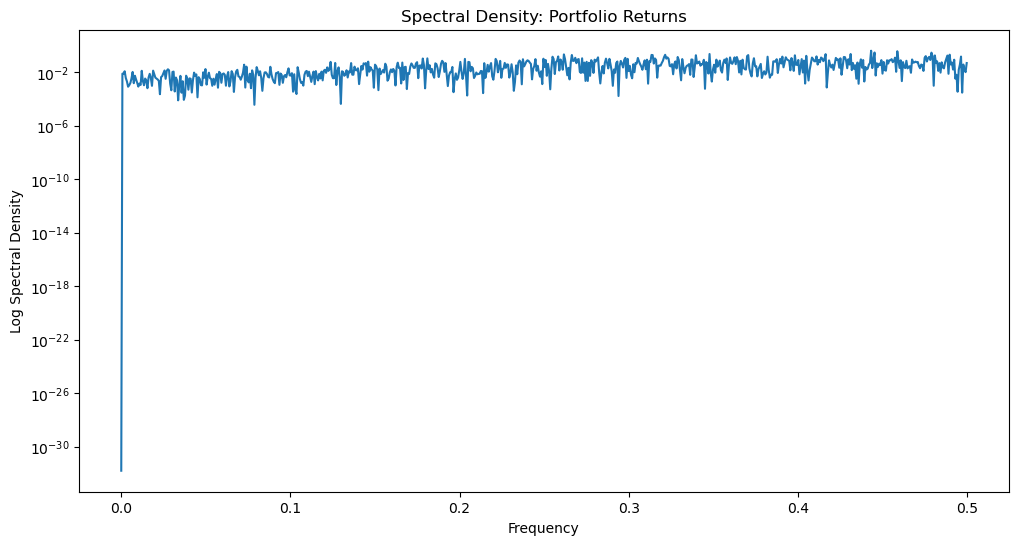


Portfolio Spectral Density Statistics:
Max: 0.42578
Min: 0.00000
Mean: 0.03821
Median: 0.01690
Standard Deviation: 0.05008


<Figure size 1200x600 with 0 Axes>

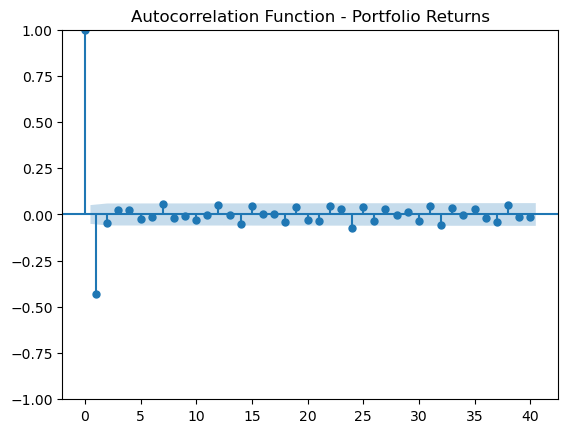

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import periodogram
import statsmodels.api as sm

def analyze_spectrum(original_data, synthetic_data):
    original_returns = original_data.pct_change().dropna()
    synthetic_returns = synthetic_data.pct_change().dropna()

    # Lists to store metrics for aggregate chart
    assets = []
    original_max_psd = []
    synthetic_max_psd = []
    original_mean_psd = []
    synthetic_mean_psd = []
    original_std_psd = []
    synthetic_std_psd = []

    for column in original_returns.columns:
        # Compute periodogram
        f_original, Pxx_original = periodogram(original_returns[column])
        f_synthetic, Pxx_synthetic = periodogram(synthetic_returns[column])

        # Store metrics for aggregate chart
        assets.append(column)
        original_max_psd.append(np.max(Pxx_original))
        synthetic_max_psd.append(np.max(Pxx_synthetic))
        original_mean_psd.append(np.mean(Pxx_original))
        synthetic_mean_psd.append(np.mean(Pxx_synthetic))
        original_std_psd.append(np.std(Pxx_original))
        synthetic_std_psd.append(np.std(Pxx_synthetic))

        # Spectral Analysis
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))

        # Spectral Analysis - Original
        axs[0].semilogy(f_original, Pxx_original)
        axs[0].set_title(f'Spectral Density: Original Returns - {column}')
        axs[0].set_xlabel('Frequency')
        axs[0].set_ylabel('Log Spectral Density')

        # Spectral Analysis - Synthetic
        axs[1].semilogy(f_synthetic, Pxx_synthetic)
        axs[1].set_title(f'Spectral Density: Synthetic Returns - {column}')
        axs[1].set_xlabel('Frequency')
        axs[1].set_ylabel('Log Spectral Density')

        plt.tight_layout()
        plt.show()

        # Compute and print statistics
        print(f"\nSpectral Analysis for {column}:")
        print("Original Returns - Spectral Density Statistics:")
        print(f"Max: {np.max(Pxx_original):.5f}")
        print(f"Min: {np.min(Pxx_original):.5f}")
        print(f"Mean: {np.mean(Pxx_original):.5f}")
        print(f"Median: {np.median(Pxx_original):.5f}")
        print(f"Standard Deviation: {np.std(Pxx_original):.5f}")

        print("\nSynthetic Returns - Spectral Density Statistics:")
        print(f"Max: {np.max(Pxx_synthetic):.5f}")
        print(f"Min: {np.min(Pxx_synthetic):.5f}")
        print(f"Mean: {np.mean(Pxx_synthetic):.5f}")
        print(f"Median: {np.median(Pxx_synthetic):.5f}")
        print(f"Standard Deviation: {np.std(Pxx_synthetic):.5f}")

        # Power Spectral Density (PSD) comparison
        plt.figure(figsize=(12, 6))
        plt.semilogy(f_original, Pxx_original, label='Original')
        plt.semilogy(f_synthetic, Pxx_synthetic, label='Synthetic')
        plt.xlabel('Frequency')
        plt.ylabel('Power Spectral Density')
        plt.title(f'Power Spectral Density Comparison - {column}')
        plt.legend()
        plt.show()

        # Autocorrelation Function
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        sm.graphics.tsa.plot_acf(original_returns[column], lags=40, alpha=0.05, title=f'ACF - Original Returns {column}', ax=ax1)
        sm.graphics.tsa.plot_acf(synthetic_returns[column], lags=40, alpha=0.05, title=f'ACF - Synthetic Returns {column}', ax=ax2)
        plt.tight_layout()
        plt.show()

    # Aggregate charts
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 24))
    x = np.arange(len(assets))
    width = 0.35

    # Max PSD comparison
    ax1.bar(x - width/2, original_max_psd, width, label='Original Max PSD')
    ax1.bar(x + width/2, synthetic_max_psd, width, label='Synthetic Max PSD')
    ax1.set_ylabel('Max PSD')
    ax1.set_title('Maximum Power Spectral Density Comparison Across Assets - UK')
    ax1.set_xticks(x)
    ax1.set_xticklabels(assets, rotation=45, ha='right')
    ax1.legend()

    # Mean PSD comparison
    ax2.bar(x - width/2, original_mean_psd, width, label='Original Mean PSD')
    ax2.bar(x + width/2, synthetic_mean_psd, width, label='Synthetic Mean PSD')
    ax2.set_ylabel('Mean PSD')
    ax2.set_title('Mean Power Spectral Density Comparison Across Assets - UK')
    ax2.set_xticks(x)
    ax2.set_xticklabels(assets, rotation=45, ha='right')
    ax2.legend()

    # Standard Deviation of PSD comparison
    ax3.bar(x - width/2, original_std_psd, width, label='Original PSD Std Dev')
    ax3.bar(x + width/2, synthetic_std_psd, width, label='Synthetic PSD Std Dev')
    ax3.set_ylabel('PSD Standard Deviation')
    ax3.set_title('Power Spectral Density Standard Deviation Comparison Across Assets - UK')
    ax3.set_xticks(x)
    ax3.set_xticklabels(assets, rotation=45, ha='right')
    ax3.legend()

    plt.tight_layout()
    plt.show()

def analyze_portfolio_spectrum(data, weights=None):
    if weights is None:
        weights = np.ones(len(data.columns)) / len(data.columns)  # Equal weights if not provided
    
    portfolio_returns = (data.pct_change().dropna() * weights).sum(axis=1)
    
    f, Pxx = periodogram(portfolio_returns)
    
    plt.figure(figsize=(12, 6))
    plt.semilogy(f, Pxx)
    plt.title('Spectral Density: Portfolio Returns')
    plt.xlabel('Frequency')
    plt.ylabel('Log Spectral Density')
    plt.show()
    
    print("\nPortfolio Spectral Density Statistics:")
    print(f"Max: {np.max(Pxx):.5f}")
    print(f"Min: {np.min(Pxx):.5f}")
    print(f"Mean: {np.mean(Pxx):.5f}")
    print(f"Median: {np.median(Pxx):.5f}")
    print(f"Standard Deviation: {np.std(Pxx):.5f}")

    # Autocorrelation Function for portfolio returns
    plt.figure(figsize=(12, 6))
    sm.graphics.tsa.plot_acf(portfolio_returns, lags=40, alpha=0.05, title='Autocorrelation Function - Portfolio Returns')
    plt.show()

# Assuming stock_data and rescaled_synthetic_data are available
# If they're not, you might need to load or recreate them here

# Perform the spectral analysis
analyze_spectrum(stock_data, rescaled_synthetic_data)

print("\nOriginal Portfolio:")
analyze_portfolio_spectrum(stock_data)

print("\nSynthetic Portfolio:")
analyze_portfolio_spectrum(rescaled_synthetic_data)